In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 


from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
from sklearn.cluster import DBSCAN

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.add('said')
ENGLISH_STOP_WORDS = frozenset(stop_words)

from collections import defaultdict
import re
import pickle

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union

In [3]:
import requests
import csv
from itertools import permutations


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

### Importing summed topics over time for Nature publications from 2005 to 2022 (see BERTopic notebook):

In [5]:
df_0 = pd.read_csv('data/nature_2005_2022_summed_topics_over_time.csv')

In [6]:
df_1 = pd.read_csv('data/nature_2005_2022_summed_topics_over_time_month.csv')

In [7]:
df_0

Topic  Timestamp                                                  Words  \
0         0       2005      infectiousness, dynavax, meters, belated, plotkin   
1         0       2006              vaccine, lyme, dextrose, toil, distrusted   
2         0       2007               sthr, klaus, novartis, vaccine, vaccines   
3         0       2008    vaccine, standardizes, selfdefence, oncequiet, 1966   
4         0       2009               jabs, vaccine, pandemics, flu, creditors   
...     ...        ...                                                    ...   
4620    308       2017    inequality, activity, smartphone, obesity, physical   
4621    308       2018             obesity, slims, heretical, cruel, galileos   
4622    308       2019            rural, bmi, obesity, bodymass, middleincome   
4623    308       2021                obesitys, born, racially, skewed, 1950s   
4624    308       2022  normalweight, underweight, engage, counterparts, stay   

      Frequency  
0             4  
1             7  
2             7  
3             8  
4             9  
...         ...  
4620          1  
4621          2  
4622          2  
4623          1  
4624          1  

[4625 rows x 4 columns]

In [8]:
df_1

Topic   Timestamp  \
0          0  2005-09-01   
1          0  2005-10-01   
2          0  2005-11-01   
3          0  2006-01-01   
4          0  2006-02-01   
...      ...         ...   
17739    308  2018-01-01   
17740    308  2018-09-01   
17741    308  2019-05-01   
17742    308  2021-04-01   
17743    308  2022-07-01   

                                                            Words  Frequency  \
0        dynavax, plotkin, vaccinology, directors, epidemiologist          1   
1              belated, acknowledgement, bushs, rhetoric, welcome          1   
2      meters, infectiousness, sneeze, infectious, superspreading          2   
3                       opposition, faith, lose, children, public          1   
4                     lyme, vaccine, dextrose, distrusted, skiers          3   
...                                                           ...        ...   
17739                    slims, procedure, surgery, persist, cuts          1   
17740               obesity, heretical, cruel, galileos, longlost          1   
17741                 rural, bmi, obesity, bodymass, middleincome          2   
17742                     obesitys, born, racially, skewed, 1950s          1   
17743       normalweight, underweight, engage, counterparts, stay          1   

                                      Name  
0      0_covid_coronavirus_covid19_vaccine  
1      0_covid_coronavirus_covid19_vaccine  
2      0_covid_coronavirus_covid19_vaccine  
3      0_covid_coronavirus_covid19_vaccine  
4      0_covid_coronavirus_covid19_vaccine  
...                                    ...  
17739       308_obesity_rural_bmi_bodymass  
17740       308_obesity_rural_bmi_bodymass  
17741       308_obesity_rural_bmi_bodymass  
17742       308_obesity_rural_bmi_bodymass  
17743       308_obesity_rural_bmi_bodymass  

[17744 rows x 5 columns]

In [9]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17744 entries, 0 to 17743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      17744 non-null  int64 
 1   Timestamp  17744 non-null  object
 2   Words      17744 non-null  object
 3   Frequency  17744 non-null  int64 
 4   Name       17744 non-null  object
dtypes: int64(2), object(3)
memory usage: 693.3+ KB


In [10]:
df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp']) 

In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17744 entries, 0 to 17743
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Topic      17744 non-null  int64         
 1   Timestamp  17744 non-null  datetime64[ns]
 2   Words      17744 non-null  object        
 3   Frequency  17744 non-null  int64         
 4   Name       17744 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 693.3+ KB


Removing entries from 2023, since not complete for the year:

In [12]:
df_0 = df_0[df_0['Timestamp'] != 2023]

In [13]:

df_1 = df_1[df_1['Timestamp'].dt.year != 2023]

Trying to make a suitable custom dataframe with the time, topic and frequency information,
the idea was to do a groupby of 'Timestamp' and 'Topic', followed by a value count of 'Frequency':

In [14]:
df_0_grouped_by_topic_year = df_0.groupby(['Timestamp', 'Topic'])

In [15]:
df_0_grouped = df_0_grouped_by_topic_year['Frequency'].value_counts().unstack()

In [17]:
df_0_grouped

Frequency        1    2    3    4    5    6    7    8    9    10   ...  65   \
Timestamp Topic                                                    ...        
2005      0      NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  ...  NaN   
          4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2022      303    NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          304    NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          305    NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          307    NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
          308    1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

Frequency        66   83   88   90   104  114  220  472  474  
Timestamp Topic                                               
2005      0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
2022      303    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          304    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          305    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          307    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          308    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[4593 rows x 70 columns]

Almost there, but I could not figure out how to change Frequency into a column, .melt() did not work with Timestamp as the index and 
an index reset changes the logic of the dataframe

Different approach, groupby of 'Topic' and 'Timestamp' and .sum() of 'Frequency',
followed by pivoting the dataframe with .pivot() and making 'Timestamp' the index, 'Topic' the columns and 
'Frequency' the values, so all three informations are in a dataframe for plotting and time series forecasting:

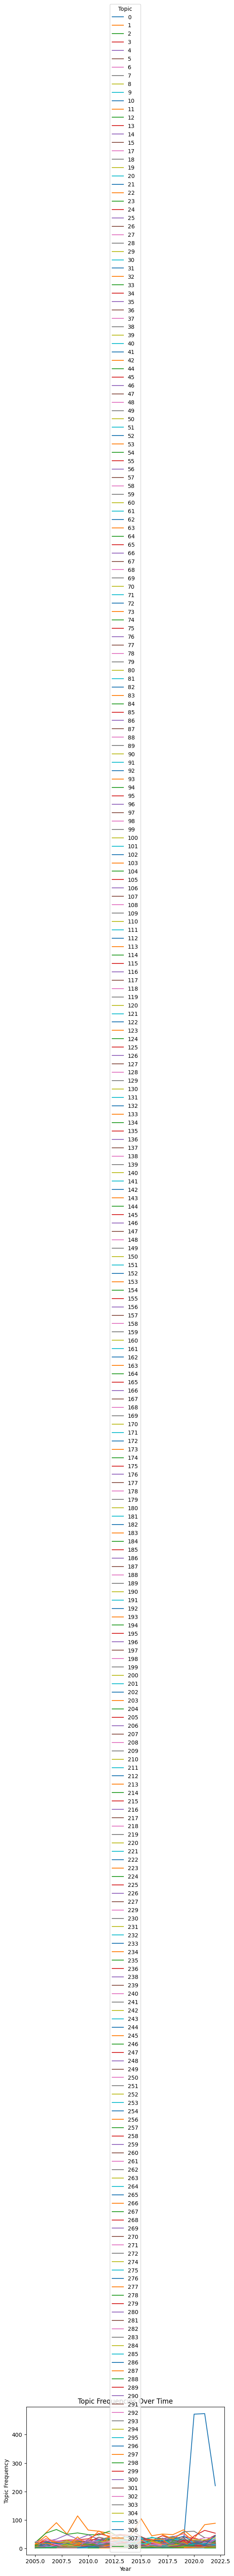

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df = df_0.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df = grouped_df.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis


With monthly data:

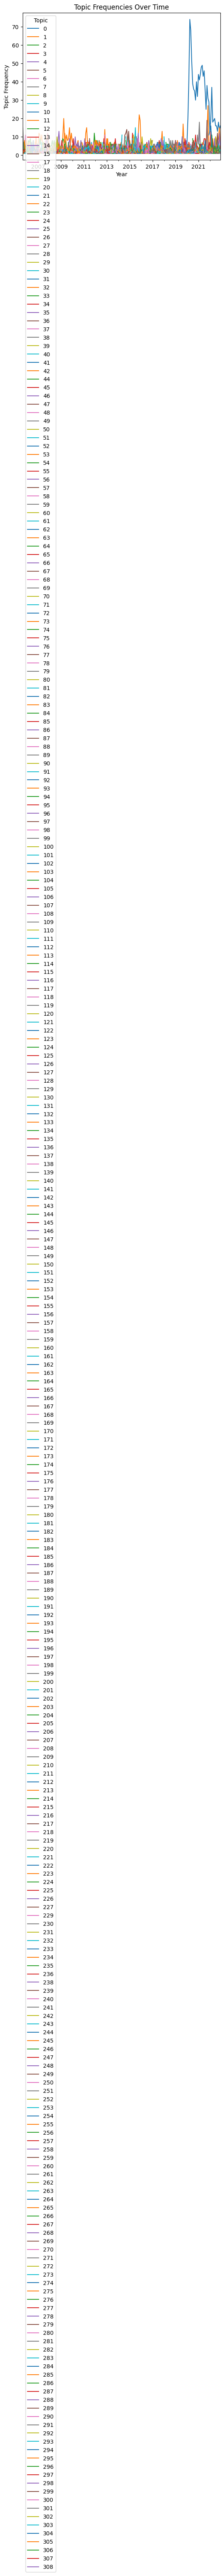

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df = df_1.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df = grouped_df.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis

Nice, this worked the way I want to, this can be used for time series modelling.

In [140]:
grouped_df 

Topic  Timestamp  Frequency
0          0 2005-09-01          1
1          0 2005-10-01          1
2          0 2005-11-01          2
3          0 2006-01-01          1
4          0 2006-02-01          3
...      ...        ...        ...
17702    308 2018-01-01          1
17703    308 2018-09-01          1
17704    308 2019-05-01          2
17705    308 2021-04-01          1
17706    308 2022-07-01          1

[17707 rows x 3 columns]

In [141]:
pivot_df  # The values in the dataframe are the topic freqencies for each topic for each year

Topic        0     1     2     3     4    5    6    7    8     9    ...  299  \
Timestamp                                                           ...        
2005-09-01   1.0   3.0   8.0   1.0   1.0  1.0  NaN  NaN  3.0   NaN  ...  NaN   
2005-10-01   1.0   2.0   6.0   2.0   7.0  1.0  3.0  2.0  4.0   NaN  ...  NaN   
2005-11-01   2.0   7.0   3.0   5.0   NaN  2.0  2.0  1.0  NaN   NaN  ...  NaN   
2005-12-01   NaN   3.0   3.0   2.0   3.0  NaN  5.0  2.0  1.0   NaN  ...  NaN   
2006-01-01   1.0   5.0   2.0   2.0   1.0  1.0  1.0  1.0  NaN   NaN  ...  NaN   
2006-02-01   3.0   3.0   3.0   4.0   3.0  1.0  2.0  1.0  1.0   NaN  ...  NaN   
2006-03-01   NaN   4.0   8.0   3.0   1.0  NaN  1.0  2.0  1.0   NaN  ...  NaN   
2006-04-01   1.0   1.0   7.0   4.0   2.0  1.0  2.0  2.0  NaN   3.0  ...  NaN   
2006-05-01   NaN   7.0   9.0   2.0   1.0  4.0  1.0  5.0  1.0   NaN  ...  NaN   
2006-06-01   1.0   7.0   4.0   3.0   NaN  NaN  1.0  2.0  1.0   1.0  ...  NaN   
2006-07-01   NaN   1.0   4.0   1.0   1.0  3.0  1.0  NaN  NaN   NaN  ...  NaN   
2006-08-01   NaN   5.0   4.0   4.0   3.0  1.0  1.0  1.0  NaN   1.0  ...  NaN   
2006-09-01   1.0   4.0   2.0   2.0   4.0  2.0  6.0  1.0  NaN   NaN  ...  NaN   
2006-10-01   NaN   4.0   3.0   4.0   2.0  2.0  3.0  3.0  NaN   NaN  ...  NaN   
2006-11-01   NaN  10.0   3.0   3.0   4.0  4.0  6.0  5.0  1.0   2.0  ...  NaN   
2006-12-01   NaN   3.0   4.0   1.0   2.0  NaN  NaN  2.0  1.0   NaN  ...  NaN   
2007-01-01   NaN   5.0   6.0   3.0   1.0  NaN  1.0  NaN  NaN   3.0  ...  NaN   
2007-02-01   NaN  12.0   2.0   1.0   1.0  3.0  1.0  3.0  1.0   NaN  ...  NaN   
2007-03-01   1.0  11.0   9.0   2.0   1.0  1.0  NaN  7.0  NaN   NaN  ...  NaN   
2007-04-01   1.0   8.0   6.0   4.0   1.0  1.0  1.0  NaN  1.0   NaN  ...  NaN   
2007-05-01   2.0  11.0   6.0   3.0   2.0  NaN  1.0  1.0  1.0   1.0  ...  NaN   
2007-06-01   1.0   3.0   6.0   2.0   5.0  3.0  NaN  1.0  1.0   1.0  ...  NaN   
2007-07-01   NaN   2.0   7.0   1.0   2.0  1.0  1.0  NaN  2.0   1.0  ...  NaN   
2007-08-01   NaN   4.0   5.0   1.0   3.0  3.0  6.0  NaN  2.0   2.0  ...  NaN   
2007-09-01   2.0   7.0   7.0   4.0   3.0  2.0  8.0  3.0  4.0   NaN  ...  NaN   
2007-10-01   NaN   8.0   1.0   2.0   8.0  2.0  4.0  1.0  2.0   1.0  ...  NaN   
2007-11-01   NaN  12.0   8.0   2.0   2.0  2.0  1.0  NaN  1.0   NaN  ...  NaN   
2007-12-01   NaN   7.0   3.0   NaN   3.0  NaN  NaN  NaN  NaN   NaN  ...  NaN   
2008-01-01   NaN   5.0   2.0   3.0   3.0  4.0  NaN  3.0  2.0   1.0  ...  NaN   
2008-02-01   1.0   4.0   5.0   3.0   3.0  2.0  NaN  1.0  NaN   NaN  ...  NaN   
2008-03-01   2.0   1.0   5.0   1.0   1.0  1.0  4.0  2.0  4.0   1.0  ...  NaN   
2008-04-01   2.0   4.0   8.0   3.0   5.0  2.0  1.0  2.0  2.0   1.0  ...  NaN   
2008-05-01   NaN   3.0   4.0   1.0   2.0  4.0  1.0  3.0  3.0   NaN  ...  NaN   
2008-06-01   1.0   NaN   8.0   2.0   5.0  1.0  1.0  NaN  1.0   NaN  ...  NaN   
2008-07-01   NaN   7.0   2.0   4.0   1.0  1.0  1.0  2.0  3.0   1.0  ...  NaN   
2008-08-01   NaN   3.0   NaN   2.0   NaN  4.0  1.0  1.0  1.0   NaN  ...  NaN   
2008-09-01   NaN   5.0   3.0   2.0   4.0  NaN  NaN  2.0  2.0   1.0  ...  NaN   
2008-10-01   NaN   8.0   6.0   3.0   7.0  1.0  3.0  2.0  1.0   2.0  ...  NaN   
2008-11-01   NaN   5.0   4.0   4.0  13.0  2.0  NaN  3.0  NaN   NaN  ...  NaN   
2008-12-01   2.0   5.0   2.0   1.0   4.0  1.0  NaN  1.0  2.0   NaN  ...  NaN   
2009-01-01   NaN   4.0   2.0   2.0   2.0  2.0  1.0  2.0  4.0   2.0  ...  NaN   
2009-02-01   NaN   4.0   5.0   8.0   1.0  1.0  2.0  5.0  3.0   NaN  ...  NaN   
2009-03-01   NaN  10.0   9.0   3.0   3.0  2.0  4.0  4.0  1.0   2.0  ...  NaN   
2009-04-01   1.0  20.0   8.0   1.0   NaN  2.0  NaN  1.0  2.0   3.0  ...  NaN   
2009-05-01   1.0   7.0   3.0   1.0   NaN  2.0  4.0  NaN  1.0   1.0  ...  NaN   
2009-06-01   NaN   7.0   8.0   4.0   NaN  NaN  4.0  1.0  1.0   1.0  ...  NaN   
2009-07-01   4.0  11.0   4.0   NaN   1.0  1.0  1.0  1.0  2.0   1.0  ...  1.0   
2009-08-01   2.0   8.0   1.0   4.0   3.0  2.0  3.0  NaN  1.0   1.0  ...  NaN   


Deleting topic 0 (Covid) as an outlier:

In [144]:
del pivot_df[0]

In [145]:
pivot_df

Topic        1     2     3     4    5    6    7    8     9    10   ...  299  \
Timestamp                                                          ...        
2005-09-01   3.0   8.0   1.0   1.0  1.0  NaN  NaN  3.0   NaN  1.0  ...  NaN   
2005-10-01   2.0   6.0   2.0   7.0  1.0  3.0  2.0  4.0   NaN  2.0  ...  NaN   
2005-11-01   7.0   3.0   5.0   NaN  2.0  2.0  1.0  NaN   NaN  2.0  ...  NaN   
2005-12-01   3.0   3.0   2.0   3.0  NaN  5.0  2.0  1.0   NaN  3.0  ...  NaN   
2006-01-01   5.0   2.0   2.0   1.0  1.0  1.0  1.0  NaN   NaN  1.0  ...  NaN   
2006-02-01   3.0   3.0   4.0   3.0  1.0  2.0  1.0  1.0   NaN  2.0  ...  NaN   
2006-03-01   4.0   8.0   3.0   1.0  NaN  1.0  2.0  1.0   NaN  1.0  ...  NaN   
2006-04-01   1.0   7.0   4.0   2.0  1.0  2.0  2.0  NaN   3.0  4.0  ...  NaN   
2006-05-01   7.0   9.0   2.0   1.0  4.0  1.0  5.0  1.0   NaN  2.0  ...  NaN   
2006-06-01   7.0   4.0   3.0   NaN  NaN  1.0  2.0  1.0   1.0  2.0  ...  NaN   
2006-07-01   1.0   4.0   1.0   1.0  3.0  1.0  NaN  NaN   NaN  1.0  ...  NaN   
2006-08-01   5.0   4.0   4.0   3.0  1.0  1.0  1.0  NaN   1.0  2.0  ...  NaN   
2006-09-01   4.0   2.0   2.0   4.0  2.0  6.0  1.0  NaN   NaN  NaN  ...  NaN   
2006-10-01   4.0   3.0   4.0   2.0  2.0  3.0  3.0  NaN   NaN  2.0  ...  NaN   
2006-11-01  10.0   3.0   3.0   4.0  4.0  6.0  5.0  1.0   2.0  4.0  ...  NaN   
2006-12-01   3.0   4.0   1.0   2.0  NaN  NaN  2.0  1.0   NaN  NaN  ...  NaN   
2007-01-01   5.0   6.0   3.0   1.0  NaN  1.0  NaN  NaN   3.0  2.0  ...  NaN   
2007-02-01  12.0   2.0   1.0   1.0  3.0  1.0  3.0  1.0   NaN  NaN  ...  NaN   
2007-03-01  11.0   9.0   2.0   1.0  1.0  NaN  7.0  NaN   NaN  1.0  ...  NaN   
2007-04-01   8.0   6.0   4.0   1.0  1.0  1.0  NaN  1.0   NaN  NaN  ...  NaN   
2007-05-01  11.0   6.0   3.0   2.0  NaN  1.0  1.0  1.0   1.0  NaN  ...  NaN   
2007-06-01   3.0   6.0   2.0   5.0  3.0  NaN  1.0  1.0   1.0  NaN  ...  NaN   
2007-07-01   2.0   7.0   1.0   2.0  1.0  1.0  NaN  2.0   1.0  2.0  ...  NaN   
2007-08-01   4.0   5.0   1.0   3.0  3.0  6.0  NaN  2.0   2.0  2.0  ...  NaN   
2007-09-01   7.0   7.0   4.0   3.0  2.0  8.0  3.0  4.0   NaN  3.0  ...  NaN   
2007-10-01   8.0   1.0   2.0   8.0  2.0  4.0  1.0  2.0   1.0  2.0  ...  NaN   
2007-11-01  12.0   8.0   2.0   2.0  2.0  1.0  NaN  1.0   NaN  2.0  ...  NaN   
2007-12-01   7.0   3.0   NaN   3.0  NaN  NaN  NaN  NaN   NaN  2.0  ...  NaN   
2008-01-01   5.0   2.0   3.0   3.0  4.0  NaN  3.0  2.0   1.0  1.0  ...  NaN   
2008-02-01   4.0   5.0   3.0   3.0  2.0  NaN  1.0  NaN   NaN  1.0  ...  NaN   
2008-03-01   1.0   5.0   1.0   1.0  1.0  4.0  2.0  4.0   1.0  3.0  ...  NaN   
2008-04-01   4.0   8.0   3.0   5.0  2.0  1.0  2.0  2.0   1.0  1.0  ...  NaN   
2008-05-01   3.0   4.0   1.0   2.0  4.0  1.0  3.0  3.0   NaN  2.0  ...  NaN   
2008-06-01   NaN   8.0   2.0   5.0  1.0  1.0  NaN  1.0   NaN  4.0  ...  NaN   
2008-07-01   7.0   2.0   4.0   1.0  1.0  1.0  2.0  3.0   1.0  3.0  ...  NaN   
2008-08-01   3.0   NaN   2.0   NaN  4.0  1.0  1.0  1.0   NaN  3.0  ...  NaN   
2008-09-01   5.0   3.0   2.0   4.0  NaN  NaN  2.0  2.0   1.0  NaN  ...  NaN   
2008-10-01   8.0   6.0   3.0   7.0  1.0  3.0  2.0  1.0   2.0  1.0  ...  NaN   
2008-11-01   5.0   4.0   4.0  13.0  2.0  NaN  3.0  NaN   NaN  2.0  ...  NaN   
2008-12-01   5.0   2.0   1.0   4.0  1.0  NaN  1.0  2.0   NaN  2.0  ...  NaN   
2009-01-01   4.0   2.0   2.0   2.0  2.0  1.0  2.0  4.0   2.0  4.0  ...  NaN   
2009-02-01   4.0   5.0   8.0   1.0  1.0  2.0  5.0  3.0   NaN  4.0  ...  NaN   
2009-03-01  10.0   9.0   3.0   3.0  2.0  4.0  4.0  1.0   2.0  1.0  ...  NaN   
2009-04-01  20.0   8.0   1.0   NaN  2.0  NaN  1.0  2.0   3.0  4.0  ...  NaN   
2009-05-01   7.0   3.0   1.0   NaN  2.0  4.0  NaN  1.0   1.0  3.0  ...  NaN   
2009-06-01   7.0   8.0   4.0   NaN  NaN  4.0  1.0  1.0   1.0  3.0  ...  NaN   
2009-07-01  11.0   4.0   NaN   1.0  1.0  1.0  1.0  2.0   1.0  3.0  ...  1.0   
2009-08-01   8.0   1.0   4.0   3.0  2.0  3.0  NaN  1.0   1.0  1.0  ...  NaN   
2009-09-01   9.0   7.0   3.0   4.0  2.0  1.0  4.0 

Visulation of Frequency over time for top 10 topics:

Removing topic 0(Covid) as an outlier:

In [21]:
new_df = df_0[(df_0['Topic'] >= 1) & (df_0['Topic'] <= 10)]

With monthly df_1:

In [22]:
new_df_2 = df_1[(df_1['Topic'] >= 1) & (df_1['Topic'] <= 10)]

In [25]:
new_df 

Topic  Timestamp  \
19       1       2005   
20       1       2006   
21       1       2007   
22       1       2008   
23       1       2009   
24       1       2010   
25       1       2011   
26       1       2012   
27       1       2013   
28       1       2014   
29       1       2015   
30       1       2016   
31       1       2017   
32       1       2018   
33       1       2019   
34       1       2020   
35       1       2021   
36       1       2022   
38       2       2005   
39       2       2006   
40       2       2007   
41       2       2008   
42       2       2009   
43       2       2010   
44       2       2011   
45       2       2012   
46       2       2013   
47       2       2014   
48       2       2015   
49       2       2016   
50       2       2017   
51       2       2018   
52       2       2019   
53       2       2020   
54       2       2021   
55       2       2022   
56       3       2005   
57       3       2006   
58       3       2007   
59       3       2008   
60       3       2009   
61       3       2010   
62       3       2011   
63       3       2012   
64       3       2013   
65       3       2014   
66       3       2015   
67       3       2016   
68       3       2017   
69       3       2018   
70       3       2019   
71       3       2020   
72       3       2021   
73       3       2022   
75       4       2005   
76       4       2006   
77       4       2007   
78       4       2008   
79       4       2009   
80       4       2010   
81       4       2011   
82       4       2012   
83       4       2013   
84       4       2014   
85       4       2015   
86       4       2016   
87       4       2017   
88       4       2018   
89       4       2019   
90       4       2020   
91       4       2021   
92       4       2022   
93       5       2005   
94       5       2006   
95       5       2007   
96       5       2008   
97       5       2009   
98       5       2010   
99       5       2011   
100      5       2012   
101      5       2013   
102      5       2014   
103      5       2015   
104      5       2016   
105      5       2017   
106      5       2018   
107      5       2019   
108      5       2020   
109      5       2021   
110      5       2022   
111      6       2005   
112      6       2006   
113      6       2007   
114      6       2008   
115      6       2009   
116      6       2010   
117      6       2011   
118      6       2012   
119      6       2013   
120      6       2014   
121      6       2015   
122      6       2016   
123      6       2017   
124      6       2018   
125      6       2019   
126      6       2020   
127      6       2021   
128      6       2022   
129      7       2005   
130      7       2006   
131      7       2007   
132      7       2008   
133      7       2009   
134      7       2010   
135      7       2011   
136      7       2012   
137      7       2013   
138      7       2014   
139      7       2015   
140      7       2016   
141      7       2017   
142      7       2018   
143      7       2019   
144      7       2020   
145      7       2021   
146      7       2022   
147      8       2005   
148      8       2006   
149      8       2007   
150      8       2008   
151      8       2009   
152      8       2010   
153      8       2011   
154      8       2012   
155      8       2013   
156      8       2014   
157      8       2015   
158      8       2016   
159      8       2017   
160      8       2018   
161      8       2019   
162      8       2020   
163      8       2021   
164      8       2022   
165      9       2006   
166      9       2007   
167      9       2008   
168      9       2009   
169      9       2010   
170      9       2011   
171      9       2012   
172      9       2013   
173      9       2014   
174      9       2015   
175      9       2016   
176      9       2017   
177      9       2018   
178      9       2019   
179      9       2020   
180  

In [24]:
new_df_2

Topic  Timestamp  \
125       1 2005-09-01   
126       1 2005-10-01   
127       1 2005-11-01   
128       1 2005-12-01   
129       1 2006-01-01   
...     ...        ...   
1918     10 2022-08-01   
1919     10 2022-09-01   
1920     10 2022-10-01   
1921     10 2022-11-01   
1922     10 2022-12-01   

                                                            Words  Frequency  \
125                       19282005, keeling, halve, 2050, charles          3   
126                   climbs, soaring, warnings, ministers, posed          2   
127                     climate, emissions, policy, petit, bamzai          7   
128               conference, kyoto, montreal, twintrack, signing          3   
129   unimpressed, clean, alternativeenergy, asiapacific, climate          5   
...                                                           ...        ...   
1918                     loved, dissonant, regarding, broken, one          2   
1919                  garden, behind, reflection, keeping, moment          2   
1920                        sisterly, invents, girl, still, place          4   
1921           struthers, watchmaker, orphans, vintage, testament          3   
1922               bremmers, gettogether, merry, christmas, quite          2   

                                    Name  
125   1_climate_emissions_change_warming  
126   1_climate_emissions_change_warming  
127   1_climate_emissions_change_warming  
128   1_climate_emissions_change_warming  
129   1_climate_emissions_change_warming  
...                                  ...  
1918           10_time_its_home_remember  
1919           10_time_its_home_remember  
1920           10_time_its_home_remember  
1921           10_time_its_home_remember  
1922           10_time_its_home_remember  

[1796 rows x 5 columns]

Plotting the frequencies over time of the top 10 topics:

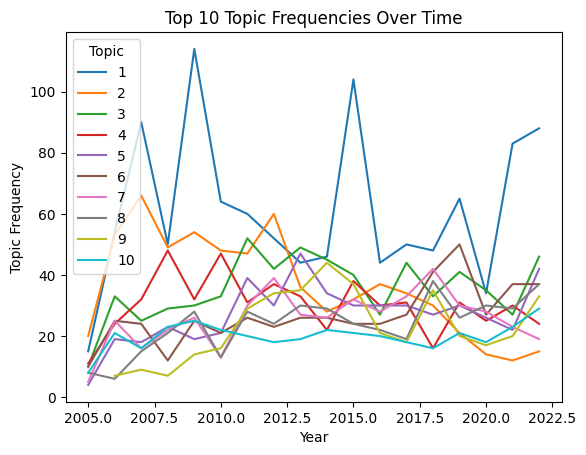

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df = new_df.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df = grouped_df.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Top 10 Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis

With monthly timestamps:

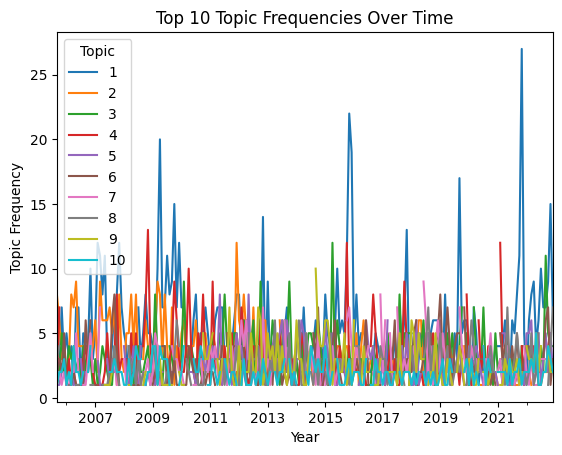

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by "Topic" and "Timestamp" and aggregate "Frequency"
grouped_df_2 = new_df_2.groupby(['Topic', 'Timestamp'])['Frequency'].sum().reset_index()

# Pivot the DataFrame to get years on the x-axis and Topic Frequencies as columns
pivot_df_2 = grouped_df_2.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Plot the data with a legend
pivot_df_2.plot(kind='line', legend=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Topic Frequency')
plt.title('Top 10 Topic Frequencies Over Time')

# Show the plot
plt.show()

# The pivot_df DataFrame can be used for time series analysis

# Timeseries modelling:

First step: Filling NaN values with zero:

In [146]:
pivot_df.fillna(0, inplace=True) 

In [147]:
pivot_df

Topic        1     2     3     4    5    6    7    8     9    10   ...  299  \
Timestamp                                                          ...        
2005-09-01   3.0   8.0   1.0   1.0  1.0  0.0  0.0  3.0   0.0  1.0  ...  0.0   
2005-10-01   2.0   6.0   2.0   7.0  1.0  3.0  2.0  4.0   0.0  2.0  ...  0.0   
2005-11-01   7.0   3.0   5.0   0.0  2.0  2.0  1.0  0.0   0.0  2.0  ...  0.0   
2005-12-01   3.0   3.0   2.0   3.0  0.0  5.0  2.0  1.0   0.0  3.0  ...  0.0   
2006-01-01   5.0   2.0   2.0   1.0  1.0  1.0  1.0  0.0   0.0  1.0  ...  0.0   
2006-02-01   3.0   3.0   4.0   3.0  1.0  2.0  1.0  1.0   0.0  2.0  ...  0.0   
2006-03-01   4.0   8.0   3.0   1.0  0.0  1.0  2.0  1.0   0.0  1.0  ...  0.0   
2006-04-01   1.0   7.0   4.0   2.0  1.0  2.0  2.0  0.0   3.0  4.0  ...  0.0   
2006-05-01   7.0   9.0   2.0   1.0  4.0  1.0  5.0  1.0   0.0  2.0  ...  0.0   
2006-06-01   7.0   4.0   3.0   0.0  0.0  1.0  2.0  1.0   1.0  2.0  ...  0.0   
2006-07-01   1.0   4.0   1.0   1.0  3.0  1.0  0.0  0.0   0.0  1.0  ...  0.0   
2006-08-01   5.0   4.0   4.0   3.0  1.0  1.0  1.0  0.0   1.0  2.0  ...  0.0   
2006-09-01   4.0   2.0   2.0   4.0  2.0  6.0  1.0  0.0   0.0  0.0  ...  0.0   
2006-10-01   4.0   3.0   4.0   2.0  2.0  3.0  3.0  0.0   0.0  2.0  ...  0.0   
2006-11-01  10.0   3.0   3.0   4.0  4.0  6.0  5.0  1.0   2.0  4.0  ...  0.0   
2006-12-01   3.0   4.0   1.0   2.0  0.0  0.0  2.0  1.0   0.0  0.0  ...  0.0   
2007-01-01   5.0   6.0   3.0   1.0  0.0  1.0  0.0  0.0   3.0  2.0  ...  0.0   
2007-02-01  12.0   2.0   1.0   1.0  3.0  1.0  3.0  1.0   0.0  0.0  ...  0.0   
2007-03-01  11.0   9.0   2.0   1.0  1.0  0.0  7.0  0.0   0.0  1.0  ...  0.0   
2007-04-01   8.0   6.0   4.0   1.0  1.0  1.0  0.0  1.0   0.0  0.0  ...  0.0   
2007-05-01  11.0   6.0   3.0   2.0  0.0  1.0  1.0  1.0   1.0  0.0  ...  0.0   
2007-06-01   3.0   6.0   2.0   5.0  3.0  0.0  1.0  1.0   1.0  0.0  ...  0.0   
2007-07-01   2.0   7.0   1.0   2.0  1.0  1.0  0.0  2.0   1.0  2.0  ...  0.0   
2007-08-01   4.0   5.0   1.0   3.0  3.0  6.0  0.0  2.0   2.0  2.0  ...  0.0   
2007-09-01   7.0   7.0   4.0   3.0  2.0  8.0  3.0  4.0   0.0  3.0  ...  0.0   
2007-10-01   8.0   1.0   2.0   8.0  2.0  4.0  1.0  2.0   1.0  2.0  ...  0.0   
2007-11-01  12.0   8.0   2.0   2.0  2.0  1.0  0.0  1.0   0.0  2.0  ...  0.0   
2007-12-01   7.0   3.0   0.0   3.0  0.0  0.0  0.0  0.0   0.0  2.0  ...  0.0   
2008-01-01   5.0   2.0   3.0   3.0  4.0  0.0  3.0  2.0   1.0  1.0  ...  0.0   
2008-02-01   4.0   5.0   3.0   3.0  2.0  0.0  1.0  0.0   0.0  1.0  ...  0.0   
2008-03-01   1.0   5.0   1.0   1.0  1.0  4.0  2.0  4.0   1.0  3.0  ...  0.0   
2008-04-01   4.0   8.0   3.0   5.0  2.0  1.0  2.0  2.0   1.0  1.0  ...  0.0   
2008-05-01   3.0   4.0   1.0   2.0  4.0  1.0  3.0  3.0   0.0  2.0  ...  0.0   
2008-06-01   0.0   8.0   2.0   5.0  1.0  1.0  0.0  1.0   0.0  4.0  ...  0.0   
2008-07-01   7.0   2.0   4.0   1.0  1.0  1.0  2.0  3.0   1.0  3.0  ...  0.0   
2008-08-01   3.0   0.0   2.0   0.0  4.0  1.0  1.0  1.0   0.0  3.0  ...  0.0   
2008-09-01   5.0   3.0   2.0   4.0  0.0  0.0  2.0  2.0   1.0  0.0  ...  0.0   
2008-10-01   8.0   6.0   3.0   7.0  1.0  3.0  2.0  1.0   2.0  1.0  ...  0.0   
2008-11-01   5.0   4.0   4.0  13.0  2.0  0.0  3.0  0.0   0.0  2.0  ...  0.0   
2008-12-01   5.0   2.0   1.0   4.0  1.0  0.0  1.0  2.0   0.0  2.0  ...  0.0   
2009-01-01   4.0   2.0   2.0   2.0  2.0  1.0  2.0  4.0   2.0  4.0  ...  0.0   
2009-02-01   4.0   5.0   8.0   1.0  1.0  2.0  5.0  3.0   0.0  4.0  ...  0.0   
2009-03-01  10.0   9.0   3.0   3.0  2.0  4.0  4.0  1.0   2.0  1.0  ...  0.0   
2009-04-01  20.0   8.0   1.0   0.0  2.0  0.0  1.0  2.0   3.0  4.0  ...  0.0   
2009-05-01   7.0   3.0   1.0   0.0  2.0  4.0  0.0  1.0   1.0  3.0  ...  0.0   
2009-06-01   7.0   8.0   4.0   0.0  0.0  4.0  1.0  1.0   1.0  3.0  ...  0.0   
2009-07-01  11.0   4.0   0.0   1.0  1.0  1.0  1.0  2.0   1.0  3.0  ...  1.0   
2009-08-01   8.0   1.0   4.0   3.0  2.0  3.0  0.0  1.0   1.0  1.0  ...  0.0   
2009-09-01   9.0   7.0   3.0   4.0  2.0  1.0  4.0 

In [148]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2005-09-01 to 2022-12-01
Columns: 304 entries, 1 to 308
dtypes: float64(304)
memory usage: 495.6 KB


Resetting the index:

In [149]:
pivot_df_2 = pivot_df.reset_index()

In [150]:
pivot_df_2

Topic  Timestamp     1     2     3     4    5    6    7    8     9  ...  299  \
0     2005-09-01   3.0   8.0   1.0   1.0  1.0  0.0  0.0  3.0   0.0  ...  0.0   
1     2005-10-01   2.0   6.0   2.0   7.0  1.0  3.0  2.0  4.0   0.0  ...  0.0   
2     2005-11-01   7.0   3.0   5.0   0.0  2.0  2.0  1.0  0.0   0.0  ...  0.0   
3     2005-12-01   3.0   3.0   2.0   3.0  0.0  5.0  2.0  1.0   0.0  ...  0.0   
4     2006-01-01   5.0   2.0   2.0   1.0  1.0  1.0  1.0  0.0   0.0  ...  0.0   
5     2006-02-01   3.0   3.0   4.0   3.0  1.0  2.0  1.0  1.0   0.0  ...  0.0   
6     2006-03-01   4.0   8.0   3.0   1.0  0.0  1.0  2.0  1.0   0.0  ...  0.0   
7     2006-04-01   1.0   7.0   4.0   2.0  1.0  2.0  2.0  0.0   3.0  ...  0.0   
8     2006-05-01   7.0   9.0   2.0   1.0  4.0  1.0  5.0  1.0   0.0  ...  0.0   
9     2006-06-01   7.0   4.0   3.0   0.0  0.0  1.0  2.0  1.0   1.0  ...  0.0   
10    2006-07-01   1.0   4.0   1.0   1.0  3.0  1.0  0.0  0.0   0.0  ...  0.0   
11    2006-08-01   5.0   4.0   4.0   3.0  1.0  1.0  1.0  0.0   1.0  ...  0.0   
12    2006-09-01   4.0   2.0   2.0   4.0  2.0  6.0  1.0  0.0   0.0  ...  0.0   
13    2006-10-01   4.0   3.0   4.0   2.0  2.0  3.0  3.0  0.0   0.0  ...  0.0   
14    2006-11-01  10.0   3.0   3.0   4.0  4.0  6.0  5.0  1.0   2.0  ...  0.0   
15    2006-12-01   3.0   4.0   1.0   2.0  0.0  0.0  2.0  1.0   0.0  ...  0.0   
16    2007-01-01   5.0   6.0   3.0   1.0  0.0  1.0  0.0  0.0   3.0  ...  0.0   
17    2007-02-01  12.0   2.0   1.0   1.0  3.0  1.0  3.0  1.0   0.0  ...  0.0   
18    2007-03-01  11.0   9.0   2.0   1.0  1.0  0.0  7.0  0.0   0.0  ...  0.0   
19    2007-04-01   8.0   6.0   4.0   1.0  1.0  1.0  0.0  1.0   0.0  ...  0.0   
20    2007-05-01  11.0   6.0   3.0   2.0  0.0  1.0  1.0  1.0   1.0  ...  0.0   
21    2007-06-01   3.0   6.0   2.0   5.0  3.0  0.0  1.0  1.0   1.0  ...  0.0   
22    2007-07-01   2.0   7.0   1.0   2.0  1.0  1.0  0.0  2.0   1.0  ...  0.0   
23    2007-08-01   4.0   5.0   1.0   3.0  3.0  6.0  0.0  2.0   2.0  ...  0.0   
24    2007-09-01   7.0   7.0   4.0   3.0  2.0  8.0  3.0  4.0   0.0  ...  0.0   
25    2007-10-01   8.0   1.0   2.0   8.0  2.0  4.0  1.0  2.0   1.0  ...  0.0   
26    2007-11-01  12.0   8.0   2.0   2.0  2.0  1.0  0.0  1.0   0.0  ...  0.0   
27    2007-12-01   7.0   3.0   0.0   3.0  0.0  0.0  0.0  0.0   0.0  ...  0.0   
28    2008-01-01   5.0   2.0   3.0   3.0  4.0  0.0  3.0  2.0   1.0  ...  0.0   
29    2008-02-01   4.0   5.0   3.0   3.0  2.0  0.0  1.0  0.0   0.0  ...  0.0   
30    2008-03-01   1.0   5.0   1.0   1.0  1.0  4.0  2.0  4.0   1.0  ...  0.0   
31    2008-04-01   4.0   8.0   3.0   5.0  2.0  1.0  2.0  2.0   1.0  ...  0.0   
32    2008-05-01   3.0   4.0   1.0   2.0  4.0  1.0  3.0  3.0   0.0  ...  0.0   
33    2008-06-01   0.0   8.0   2.0   5.0  1.0  1.0  0.0  1.0   0.0  ...  0.0   
34    2008-07-01   7.0   2.0   4.0   1.0  1.0  1.0  2.0  3.0   1.0  ...  0.0   
35    2008-08-01   3.0   0.0   2.0   0.0  4.0  1.0  1.0  1.0   0.0  ...  0.0   
36    2008-09-01   5.0   3.0   2.0   4.0  0.0  0.0  2.0  2.0   1.0  ...  0.0   
37    2008-10-01   8.0   6.0   3.0   7.0  1.0  3.0  2.0  1.0   2.0  ...  0.0   
38    2008-11-01   5.0   4.0   4.0  13.0  2.0  0.0  3.0  0.0   0.0  ...  0.0   
39    2008-12-01   5.0   2.0   1.0   4.0  1.0  0.0  1.0  2.0   0.0  ...  0.0   
40    2009-01-01   4.0   2.0   2.0   2.0  2.0  1.0  2.0  4.0   2.0  ...  0.0   
41    2009-02-01   4.0   5.0   8.0   1.0  1.0  2.0  5.0  3.0   0.0  ...  0.0   
42    2009-03-01  10.0   9.0   3.0   3.0  2.0  4.0  4.0  1.0   2.0  ...  0.0   
43    2009-04-01  20.0   8.0   1.0   0.0  2.0  0.0  1.0  2.0   3.0  ...  0.0   
44    2009-05-01   7.0   3.0   1.0   0.0  2.0  4.0  0.0  1.0   1.0  ...  0.0   
45    2009-06-01   7.0   8.0   4.0   0.0  0.0  4.0  1.0  1.0   1.0  ...  0.0   
46    2009-07-01  11.0   4.0   0.0   1.0  1.0  1.0  1.0  2.0   1.0  ...  1.0   
47    2009-08-01   8.0   1.0   4.0   3.0  2.0  3.0  0.0  1.0   1.0  ...  0.0   
48    2009-09-01   9.0   7.0   3.0   4.0  2.0  1.0  4.0  0.0   1.0  ...  0.0   


Somehow index has 'Topic' as header, trying to change that:

In [151]:
pivot_df_2.Topic = 'Index'

In [152]:
pivot_df_2

Topic  Timestamp     1     2     3     4    5    6    7    8     9  ...  299  \
0     2005-09-01   3.0   8.0   1.0   1.0  1.0  0.0  0.0  3.0   0.0  ...  0.0   
1     2005-10-01   2.0   6.0   2.0   7.0  1.0  3.0  2.0  4.0   0.0  ...  0.0   
2     2005-11-01   7.0   3.0   5.0   0.0  2.0  2.0  1.0  0.0   0.0  ...  0.0   
3     2005-12-01   3.0   3.0   2.0   3.0  0.0  5.0  2.0  1.0   0.0  ...  0.0   
4     2006-01-01   5.0   2.0   2.0   1.0  1.0  1.0  1.0  0.0   0.0  ...  0.0   
5     2006-02-01   3.0   3.0   4.0   3.0  1.0  2.0  1.0  1.0   0.0  ...  0.0   
6     2006-03-01   4.0   8.0   3.0   1.0  0.0  1.0  2.0  1.0   0.0  ...  0.0   
7     2006-04-01   1.0   7.0   4.0   2.0  1.0  2.0  2.0  0.0   3.0  ...  0.0   
8     2006-05-01   7.0   9.0   2.0   1.0  4.0  1.0  5.0  1.0   0.0  ...  0.0   
9     2006-06-01   7.0   4.0   3.0   0.0  0.0  1.0  2.0  1.0   1.0  ...  0.0   
10    2006-07-01   1.0   4.0   1.0   1.0  3.0  1.0  0.0  0.0   0.0  ...  0.0   
11    2006-08-01   5.0   4.0   4.0   3.0  1.0  1.0  1.0  0.0   1.0  ...  0.0   
12    2006-09-01   4.0   2.0   2.0   4.0  2.0  6.0  1.0  0.0   0.0  ...  0.0   
13    2006-10-01   4.0   3.0   4.0   2.0  2.0  3.0  3.0  0.0   0.0  ...  0.0   
14    2006-11-01  10.0   3.0   3.0   4.0  4.0  6.0  5.0  1.0   2.0  ...  0.0   
15    2006-12-01   3.0   4.0   1.0   2.0  0.0  0.0  2.0  1.0   0.0  ...  0.0   
16    2007-01-01   5.0   6.0   3.0   1.0  0.0  1.0  0.0  0.0   3.0  ...  0.0   
17    2007-02-01  12.0   2.0   1.0   1.0  3.0  1.0  3.0  1.0   0.0  ...  0.0   
18    2007-03-01  11.0   9.0   2.0   1.0  1.0  0.0  7.0  0.0   0.0  ...  0.0   
19    2007-04-01   8.0   6.0   4.0   1.0  1.0  1.0  0.0  1.0   0.0  ...  0.0   
20    2007-05-01  11.0   6.0   3.0   2.0  0.0  1.0  1.0  1.0   1.0  ...  0.0   
21    2007-06-01   3.0   6.0   2.0   5.0  3.0  0.0  1.0  1.0   1.0  ...  0.0   
22    2007-07-01   2.0   7.0   1.0   2.0  1.0  1.0  0.0  2.0   1.0  ...  0.0   
23    2007-08-01   4.0   5.0   1.0   3.0  3.0  6.0  0.0  2.0   2.0  ...  0.0   
24    2007-09-01   7.0   7.0   4.0   3.0  2.0  8.0  3.0  4.0   0.0  ...  0.0   
25    2007-10-01   8.0   1.0   2.0   8.0  2.0  4.0  1.0  2.0   1.0  ...  0.0   
26    2007-11-01  12.0   8.0   2.0   2.0  2.0  1.0  0.0  1.0   0.0  ...  0.0   
27    2007-12-01   7.0   3.0   0.0   3.0  0.0  0.0  0.0  0.0   0.0  ...  0.0   
28    2008-01-01   5.0   2.0   3.0   3.0  4.0  0.0  3.0  2.0   1.0  ...  0.0   
29    2008-02-01   4.0   5.0   3.0   3.0  2.0  0.0  1.0  0.0   0.0  ...  0.0   
30    2008-03-01   1.0   5.0   1.0   1.0  1.0  4.0  2.0  4.0   1.0  ...  0.0   
31    2008-04-01   4.0   8.0   3.0   5.0  2.0  1.0  2.0  2.0   1.0  ...  0.0   
32    2008-05-01   3.0   4.0   1.0   2.0  4.0  1.0  3.0  3.0   0.0  ...  0.0   
33    2008-06-01   0.0   8.0   2.0   5.0  1.0  1.0  0.0  1.0   0.0  ...  0.0   
34    2008-07-01   7.0   2.0   4.0   1.0  1.0  1.0  2.0  3.0   1.0  ...  0.0   
35    2008-08-01   3.0   0.0   2.0   0.0  4.0  1.0  1.0  1.0   0.0  ...  0.0   
36    2008-09-01   5.0   3.0   2.0   4.0  0.0  0.0  2.0  2.0   1.0  ...  0.0   
37    2008-10-01   8.0   6.0   3.0   7.0  1.0  3.0  2.0  1.0   2.0  ...  0.0   
38    2008-11-01   5.0   4.0   4.0  13.0  2.0  0.0  3.0  0.0   0.0  ...  0.0   
39    2008-12-01   5.0   2.0   1.0   4.0  1.0  0.0  1.0  2.0   0.0  ...  0.0   
40    2009-01-01   4.0   2.0   2.0   2.0  2.0  1.0  2.0  4.0   2.0  ...  0.0   
41    2009-02-01   4.0   5.0   8.0   1.0  1.0  2.0  5.0  3.0   0.0  ...  0.0   
42    2009-03-01  10.0   9.0   3.0   3.0  2.0  4.0  4.0  1.0   2.0  ...  0.0   
43    2009-04-01  20.0   8.0   1.0   0.0  2.0  0.0  1.0  2.0   3.0  ...  0.0   
44    2009-05-01   7.0   3.0   1.0   0.0  2.0  4.0  0.0  1.0   1.0  ...  0.0   
45    2009-06-01   7.0   8.0   4.0   0.0  0.0  4.0  1.0  1.0   1.0  ...  0.0   
46    2009-07-01  11.0   4.0   0.0   1.0  1.0  1.0  1.0  2.0   1.0  ...  1.0   
47    2009-08-01   8.0   1.0   4.0   3.0  2.0  3.0  0.0  1.0   1.0  ...  0.0   
48    2009-09-01   9.0   7.0   3.0   4.0  2.0  1.0  4.0  0.0   1.0  ...  0.0   


Unfortunately this did not work.

Resetting the index:

In [153]:
pivot_df_3 = pivot_df_2.reset_index()

In [154]:
pivot_df_3

Topic  index  Timestamp     1     2     3     4    5    6    7    8  ...  299  \
0          0 2005-09-01   3.0   8.0   1.0   1.0  1.0  0.0  0.0  3.0  ...  0.0   
1          1 2005-10-01   2.0   6.0   2.0   7.0  1.0  3.0  2.0  4.0  ...  0.0   
2          2 2005-11-01   7.0   3.0   5.0   0.0  2.0  2.0  1.0  0.0  ...  0.0   
3          3 2005-12-01   3.0   3.0   2.0   3.0  0.0  5.0  2.0  1.0  ...  0.0   
4          4 2006-01-01   5.0   2.0   2.0   1.0  1.0  1.0  1.0  0.0  ...  0.0   
5          5 2006-02-01   3.0   3.0   4.0   3.0  1.0  2.0  1.0  1.0  ...  0.0   
6          6 2006-03-01   4.0   8.0   3.0   1.0  0.0  1.0  2.0  1.0  ...  0.0   
7          7 2006-04-01   1.0   7.0   4.0   2.0  1.0  2.0  2.0  0.0  ...  0.0   
8          8 2006-05-01   7.0   9.0   2.0   1.0  4.0  1.0  5.0  1.0  ...  0.0   
9          9 2006-06-01   7.0   4.0   3.0   0.0  0.0  1.0  2.0  1.0  ...  0.0   
10        10 2006-07-01   1.0   4.0   1.0   1.0  3.0  1.0  0.0  0.0  ...  0.0   
11        11 2006-08-01   5.0   4.0   4.0   3.0  1.0  1.0  1.0  0.0  ...  0.0   
12        12 2006-09-01   4.0   2.0   2.0   4.0  2.0  6.0  1.0  0.0  ...  0.0   
13        13 2006-10-01   4.0   3.0   4.0   2.0  2.0  3.0  3.0  0.0  ...  0.0   
14        14 2006-11-01  10.0   3.0   3.0   4.0  4.0  6.0  5.0  1.0  ...  0.0   
15        15 2006-12-01   3.0   4.0   1.0   2.0  0.0  0.0  2.0  1.0  ...  0.0   
16        16 2007-01-01   5.0   6.0   3.0   1.0  0.0  1.0  0.0  0.0  ...  0.0   
17        17 2007-02-01  12.0   2.0   1.0   1.0  3.0  1.0  3.0  1.0  ...  0.0   
18        18 2007-03-01  11.0   9.0   2.0   1.0  1.0  0.0  7.0  0.0  ...  0.0   
19        19 2007-04-01   8.0   6.0   4.0   1.0  1.0  1.0  0.0  1.0  ...  0.0   
20        20 2007-05-01  11.0   6.0   3.0   2.0  0.0  1.0  1.0  1.0  ...  0.0   
21        21 2007-06-01   3.0   6.0   2.0   5.0  3.0  0.0  1.0  1.0  ...  0.0   
22        22 2007-07-01   2.0   7.0   1.0   2.0  1.0  1.0  0.0  2.0  ...  0.0   
23        23 2007-08-01   4.0   5.0   1.0   3.0  3.0  6.0  0.0  2.0  ...  0.0   
24        24 2007-09-01   7.0   7.0   4.0   3.0  2.0  8.0  3.0  4.0  ...  0.0   
25        25 2007-10-01   8.0   1.0   2.0   8.0  2.0  4.0  1.0  2.0  ...  0.0   
26        26 2007-11-01  12.0   8.0   2.0   2.0  2.0  1.0  0.0  1.0  ...  0.0   
27        27 2007-12-01   7.0   3.0   0.0   3.0  0.0  0.0  0.0  0.0  ...  0.0   
28        28 2008-01-01   5.0   2.0   3.0   3.0  4.0  0.0  3.0  2.0  ...  0.0   
29        29 2008-02-01   4.0   5.0   3.0   3.0  2.0  0.0  1.0  0.0  ...  0.0   
30        30 2008-03-01   1.0   5.0   1.0   1.0  1.0  4.0  2.0  4.0  ...  0.0   
31        31 2008-04-01   4.0   8.0   3.0   5.0  2.0  1.0  2.0  2.0  ...  0.0   
32        32 2008-05-01   3.0   4.0   1.0   2.0  4.0  1.0  3.0  3.0  ...  0.0   
33        33 2008-06-01   0.0   8.0   2.0   5.0  1.0  1.0  0.0  1.0  ...  0.0   
34        34 2008-07-01   7.0   2.0   4.0   1.0  1.0  1.0  2.0  3.0  ...  0.0   
35        35 2008-08-01   3.0   0.0   2.0   0.0  4.0  1.0  1.0  1.0  ...  0.0   
36        36 2008-09-01   5.0   3.0   2.0   4.0  0.0  0.0  2.0  2.0  ...  0.0   
37        37 2008-10-01   8.0   6.0   3.0   7.0  1.0  3.0  2.0  1.0  ...  0.0   
38        38 2008-11-01   5.0   4.0   4.0  13.0  2.0  0.0  3.0  0.0  ...  0.0   
39        39 2008-12-01   5.0   2.0   1.0   4.0  1.0  0.0  1.0  2.0  ...  0.0   
40        40 2009-01-01   4.0   2.0   2.0   2.0  2.0  1.0  2.0  4.0  ...  0.0   
41        41 2009-02-01   4.0   5.0   8.0   1.0  1.0  2.0  5.0  3.0  ...  0.0   
42        42 2009-03-01  10.0   9.0   3.0   3.0  2.0  4.0  4.0  1.0  ...  0.0   
43        43 2009-04-01  20.0   8.0   1.0   0.0  2.0  0.0  1.0  2.0  ...  0.0   
44        44 2009-05-01   7.0   3.0   1.0   0.0  2.0  4.0  0.0  1.0  ...  0.0   
45        45 2009-06-01   7.0   8.0   4.0   0.0  0.0  4.0  1.0  1.0  ...  0.0   
46        46 2009-07-01  11.0   4.0   0.0   1.0  1.0  1.0  1.0  2.0  ...  1.0   
47        47 2009-08-01   8.0   1.0   4.0   3.0  2.0  3.0  0.0  1.0  ...  0.0   
48        48 2009-09-01   9.0  

In [155]:
pivot_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Columns: 306 entries, index to 308
dtypes: datetime64[ns](1), float64(304), int64(1)
memory usage: 497.4 KB


Topic remains as the header of the index.
'Topic' index column could not be deleted, therefore 'index' column will be deleted to not have it twice:

In [156]:
del pivot_df_3['index']

Index has Topic as header, but otherwise this dataframe looks like I want it to.

In [165]:
pivot_df_3.to_csv('Nature_2005_2022_prepped_for_time_series.csv')

In [110]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_importance


In [157]:
# Separating the training set and testing set
train_data=pivot_df_3[pivot_df_3['Timestamp'].dt.year<2018].reset_index(drop = True)
test_data=pivot_df_3[pivot_df_3['Timestamp'].dt.year>2017].reset_index(drop = True)

In [158]:
train_data.head()

Topic  Timestamp    1    2    3    4    5    6    7    8    9  ...  299  300  \
0     2005-09-01  3.0  8.0  1.0  1.0  1.0  0.0  0.0  3.0  0.0  ...  0.0  0.0   
1     2005-10-01  2.0  6.0  2.0  7.0  1.0  3.0  2.0  4.0  0.0  ...  0.0  0.0   
2     2005-11-01  7.0  3.0  5.0  0.0  2.0  2.0  1.0  0.0  0.0  ...  0.0  0.0   
3     2005-12-01  3.0  3.0  2.0  3.0  0.0  5.0  2.0  1.0  0.0  ...  0.0  1.0   
4     2006-01-01  5.0  2.0  2.0  1.0  1.0  1.0  1.0  0.0  0.0  ...  0.0  0.0   

Topic  301  302  303  304  305  306  307  308  
0      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1      0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  
2      2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 305 columns]

Topic should be Index, cannot change that, the topics are the columns 1 to 308.

In [159]:
# Define the target column (Topic you want to forecast)
target_topic = 1  # Change this to the Topic you want to forecast

# Prepare the training and testing data
X_train = train_data.drop(target_topic, axis=1)
y_train = train_data[target_topic]  # Shift by 1 to align with next year's frequency
X_test = test_data.drop(target_topic, axis=1)
y_test = test_data[target_topic]


Trying out forecast modelling with XGBoost:

Root Mean Squared Error (RMSE): 4.605866542546365


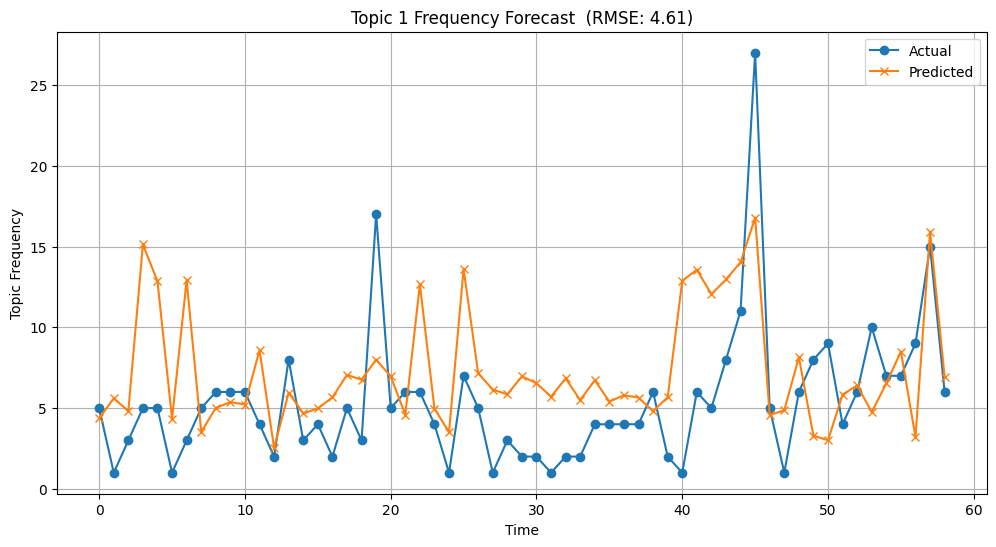

In [161]:

# Shift the target column to align with next year's frequency
y_train = train_data[target_topic].shift(-1).dropna()
y_test = test_data[target_topic].shift(-1).dropna()

# Exclude the 'Timestamp' column from the training and testing data
X_train = train_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]
X_test = test_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]

# Create an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:-1], y_test, label='Actual', marker='o')
plt.plot(test_data.index[:-1], y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Topic Frequency')
plt.title(f'Topic {target_topic} Frequency Forecast  (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)

# Feature importance plot (optional)
# plot_importance(model)
plt.show()


This look good, but time information got lost, because timestamp column needed to be exclueded from the dataframe for modelling. 

Solving this issue by creating a dataframe with 'Timestamp' and the predicted values after modelling,
this dataframe can then be merged with the original test data to get a dataframe with the predicted values in a time dependent manner.
Then a forecasting plot can be created by combining three subplots for the train data, the predicted values and the actual values:


Root Mean Squared Error (RMSE): 4.605866542546365


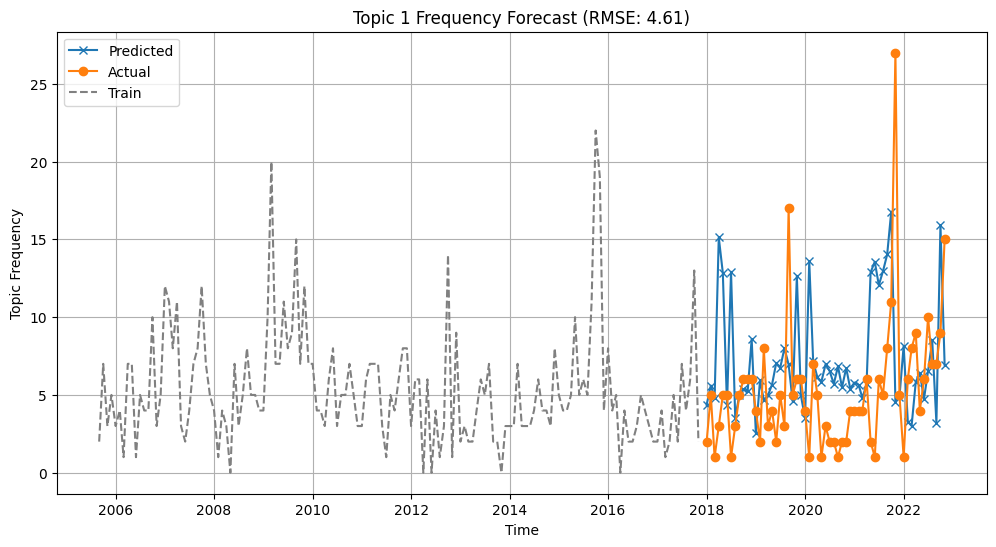

In [163]:
# Shift the target column to align with next year's frequency
y_train = train_data[target_topic].shift(-1).dropna()
y_test = test_data[target_topic].shift(-1).dropna()

# Exclude the 'Timestamp' column from the training and testing data
X_train = train_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]
X_test = test_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]

# Create an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Create a DataFrame with Timestamp and the predicted values
y_pred_df = pd.DataFrame({'Timestamp': test_data['Timestamp'].iloc[:-1], 'Predicted': y_pred})

# Merge the predicted DataFrame with the original test_data DataFrame
merged_data = pd.merge(y_pred_df, test_data, on='Timestamp')

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predicted vs. actual values along with y_train
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Timestamp'], merged_data['Predicted'], label='Predicted', marker='x')
plt.plot(merged_data['Timestamp'], merged_data[target_topic], label='Actual', marker='o')
plt.plot(train_data['Timestamp'].iloc[:-1], y_train, label='Train', linestyle='--', color='gray')
plt.xlabel('Time')
plt.ylabel('Topic Frequency')
plt.title(f'Topic {target_topic} Frequency Forecast (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)

# Feature importance plot (optional)
# plot_importance(model)
plt.show()

This looks nice, happy with this result.

Now with future forecasting and as a function:

In [194]:
def plot_bertopic_data_into_future_monthly(topic_number, future_months):

    target_topic = topic_number  

    ## number of months into the future to forecast
    n = future_months 

    target_column = pivot_df_3[target_topic]

    target_column.drop(target_column.head(n).index, inplace = True)

    untarget_columns = pivot_df_3.drop(target_topic, axis=1)

    X_forecasting_data = untarget_columns.tail(n)
    X_forecasting_months = untarget_columns['Timestamp'].tail(n) + pd.offsets.DateOffset(months=n)
    X_forecasting_data['Timestamp'] = X_forecasting_months
    X_forecasting = X_forecasting_data.drop(columns=['Timestamp'])    

    untarget_columns.drop(target_column.tail(n).index, inplace = True)

    df_1 = pd.concat([untarget_columns, target_column.reset_index(drop=True)], axis=1)

    ## shift the prediction of each year
    df_1['Timestamp'] = df_1['Timestamp'] + pd.offsets.DateOffset(months=n)

    pivot_df = df_1

     # Separating the training set and testing set
    train_data=pivot_df[pivot_df['Timestamp'].dt.year<2018].reset_index(drop = True)
    test_data=pivot_df[pivot_df['Timestamp'].dt.year>2017].reset_index(drop = True)

    # Prepare the training and testing data
    X_train = train_data.drop(target_topic, axis=1)
    X_test = test_data.drop(target_topic, axis=1)

    # Shift the target column to align with next year's frequency
    y_train = train_data[target_topic].shift(-1).dropna()
    y_test = test_data[target_topic].shift(-1).dropna()

    # Exclude the 'YearMonth' column from the training and testing data
    X_train = train_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]
    X_test = test_data.drop(columns=['Timestamp', target_topic]).iloc[:-1]

    # Create an XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_forecasting = model.predict(X_forecasting)

    # Create a DataFrame with YearMonth and the predicted values
    y_pred_df = pd.DataFrame({'Timestamp': test_data['Timestamp'].iloc[:-1], 'Predicted': y_pred})
    y_fore_df = pd.DataFrame({'Timestamp': X_forecasting_months, 'Forecasted': y_forecasting})

    # Merge the predicted DataFrame with the original test_data DataFrame
    merged_data = pd.merge(y_pred_df, test_data, on='Timestamp')
    merged_forecasted_data = pd.merge(y_fore_df, X_forecasting_data, on='Timestamp')

    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    
    y_actual_test_df = test_data[['Timestamp',target_topic]]
    y_actual_train_df = train_data[['Timestamp',target_topic]]
    y_fore_df =y_fore_df.rename(columns={'Forecasted': target_topic})
    y_pred_df =y_pred_df.rename(columns={'Predicted': target_topic})

    y_actual_test_df['value'] = 'Actual_Test'
    y_actual_train_df['value'] = 'Actual_Train'
    y_fore_df['value'] = 'Forecasted'
    y_pred_df['value'] = 'Predicted_Test'


    # Plot the predicted vs. actual values along with y_train
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['Timestamp'], merged_data['Predicted'], label='Predicted', marker='x')
    plt.plot(merged_data['Timestamp'], merged_data[target_topic], label='Actual', marker='o')
    plt.plot(train_data['Timestamp'].iloc[:-1], y_train, label='Train', linestyle='--', color='gray')
    plt.plot(merged_forecasted_data['Timestamp'], merged_forecasted_data['Forecasted'], label='Forecasted', marker='+')
    
    plt.xlabel('Time')
    plt.ylabel('Topic Frequency')
    plt.title(f'Topic {target_topic} Frequency Forecast (RMSE: {rmse:.2f})')
    plt.legend()
    plt.grid(True)

    # Feature importance plot (optional)
    #plot_importance(model)
    plt.show()

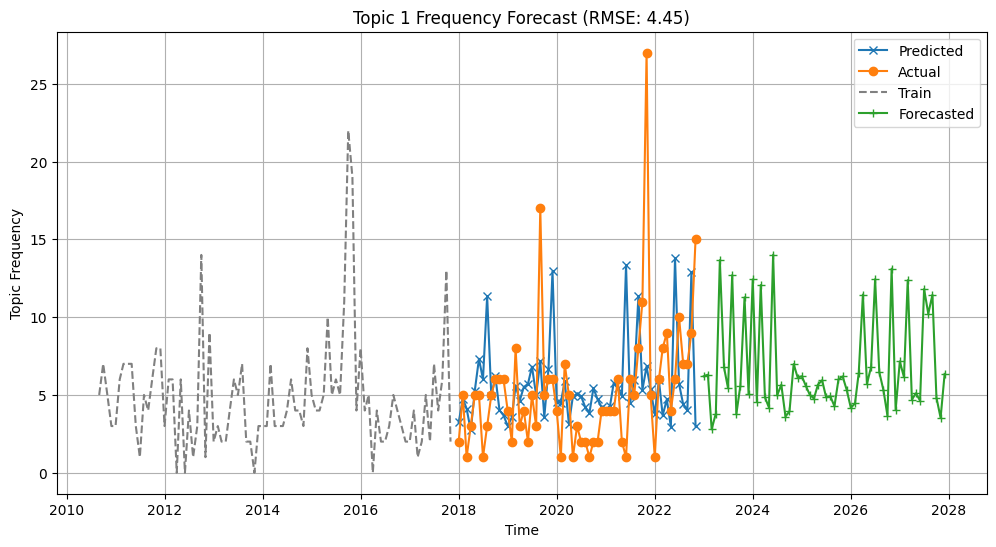

In [195]:
plot_bertopic_data_into_future_monthly(1, 60) 

Nice, this looks good.

For top 30 topics:

Explanation of the topics:

In [180]:
from bertopic import BERTopic

In [182]:
loaded_model = BERTopic.load("nature_bertopic_2015_2020_min_topic_size_25.brt")

In [183]:
topics = loaded_model.get_topics()

In [186]:
loaded_model.get_topic_info().head(33)

Topic  Count                                          Name  \
0      -1  21992                    -1_cells_cancer_cell_human   
1       0   1303           0_covid_coronavirus_covid19_vaccine   
2       1   1106            1_climate_emissions_change_warming   
3       2    656                  2_drug_biotech_patent_trials   
4       3    642       3_fossil_vertebrates_dinosaur_dinosaurs   
5       4    542          4_variants_genome_sequencing_genetic   
6       5    491                   5_mantle_earths_plate_crust   
7       6    485       6_hominin_neanderthals_cave_neanderthal   
8       7    464               7_ice_antarctic_sheet_greenland   
9       8    427                  8_carbon_forests_forest_soil   
10      9    396                  9_galaxies_galaxy_black_hole   
11     10    360                     10_time_its_home_remember   
12     11    353       11_nuclear_fukushima_reactors_chernobyl   
13     12    353              12_planets_planet_exoplanet_star   
14     13    333       13_earthquake_earthquakes_tsunami_fault   
15     14    323       14_dna_repair_replication_recombination   
16     15    319    15_neuroscience_brain_neuroscientists_mind   
17     16    312               16_career_phd_academia_graduate   
18     17    305               17_stemcell_stem_hwang_unproven   
19     18    298                    18_women_gender_female_men   
20     19    278             19_visual_neurons_cortex_dopamine   
21     20    271              20_china_chinese_chinas_research   
22     21    252            21_food_agriculture_farming_hunger   
23     22    243                  22_flu_influenza_avian_virus   
24     23    238       23_quantum_computers_computing_computer   
25     24    235              24_cancer_breast_tumours_cancers   
26     25    232        25_immunotherapy_tumour_immune_tumours   
27     26    230              26_ebola_outbreak_epidemic_virus   
28     27    219  27_biodiversity_conservation_protected_areas   
29     28    215          28_paper_correction_author_amendment   
30     29    211                29_higgs_collider_particle_lhc   
31     30    210             30_plant_auxin_arabidopsis_plants   
32     31    205       31_crispr_editing_geneediting_offtarget   

                                                                                         Representation  \
0                      [cells, cancer, cell, human, new, research, gene, science, protein, development]   
1           [covid, coronavirus, covid19, vaccine, pandemic, vaccines, daily, briefing, plus, sarscov2]   
2            [climate, emissions, change, warming, carbon, energy, paris, global, talks, greenhousegas]   
3   [drug, biotech, patent, trials, industry, drugs, pharmaceutical, biotechnology, clinical, compan...   
4   [fossil, vertebrates, dinosaur, dinosaurs, vertebrate, fossils, evolutionary, evolution, jawed, ...   
5       [variants, genome, sequencing, genetic, genomics, variation, human, individuals, genomes, rare]   
6                    [mantle, earths, plate, crust, magma, volcanic, eruption, earth, seismic, volcano]   
7                   [hominin, neanderthals, cave, neanderthal, homo, ago, modern, years, stone, humans]   
8              [ice, antarctic, sheet, greenland, sealevel, sea, antarctica, arctic, glacial, icesheet]   
9                [carbon, forests, forest, soil, tropical, trees, amazon, deforestation, land, climate]   
10                         [galaxies, galaxy, black, hole, stars, star, gas, universe, holes, galactic]   
11                           [time, its, home, remember, happiness, gift, life, christmas, happy, love]   
12  [nuclear, fukushima, reactors, chernobyl, weapons, radiation, power, plutonium, radioactive, waste]   
13        [planets, planet, exoplanet, star, exoplanets, stars, planetary, orbiting, jupiter, jupiters]   
14          [earthquake, earthquakes, tsunami, fault, quake, seismic, slip, faults, quakes, megathrust]   
15  [dna, repair, replication, recombination, t

Using a for loop to use the function for the topics 1 to 32 except 16, since it was removed from the data for modelling
as a non-sensical topic:

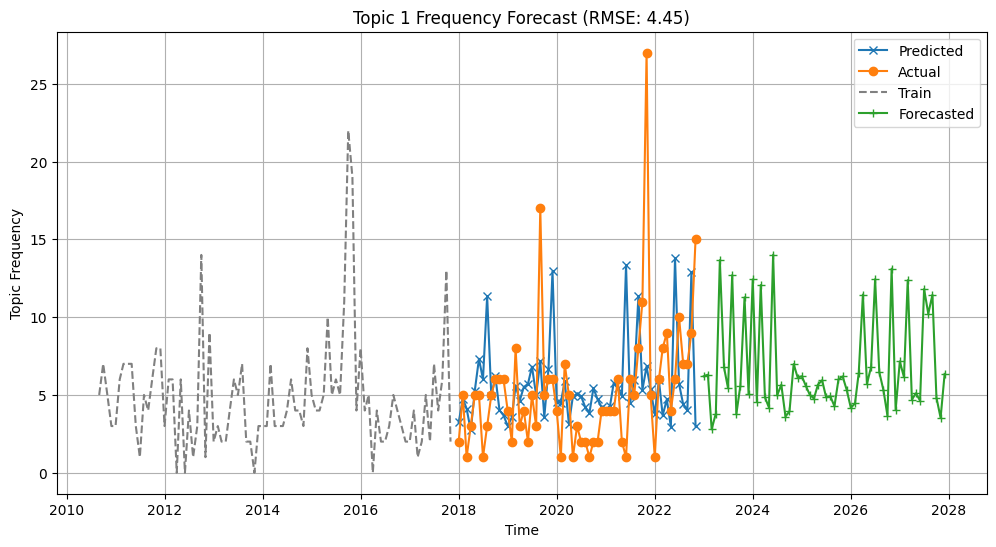

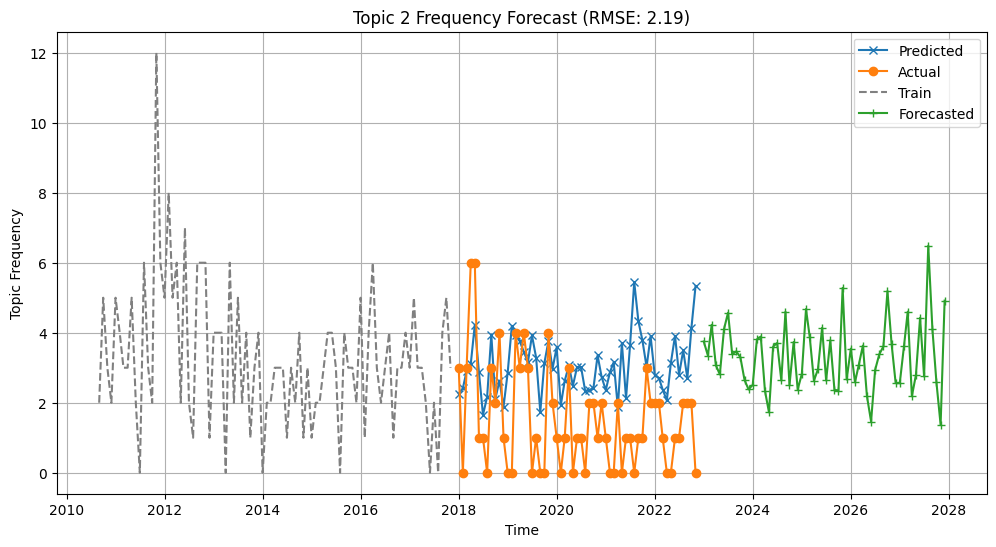

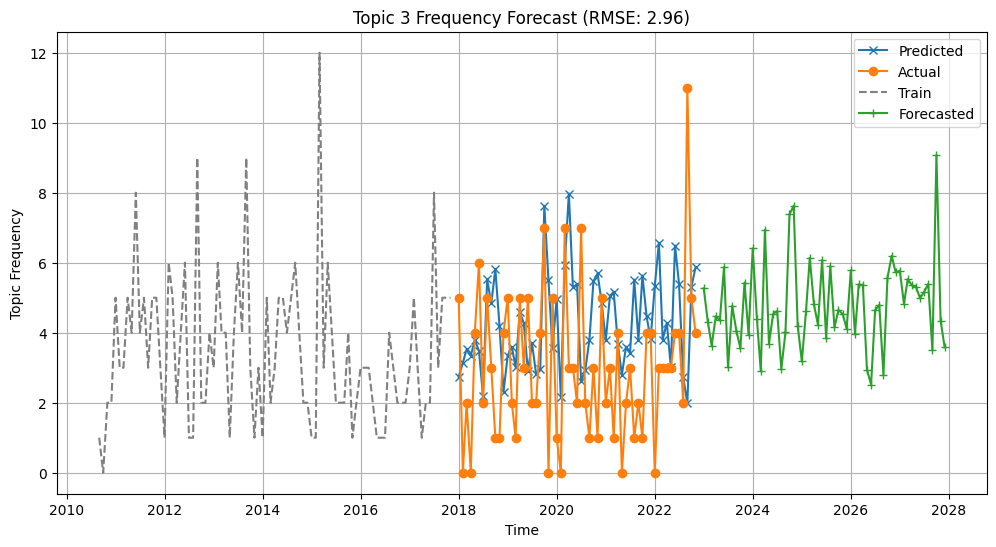

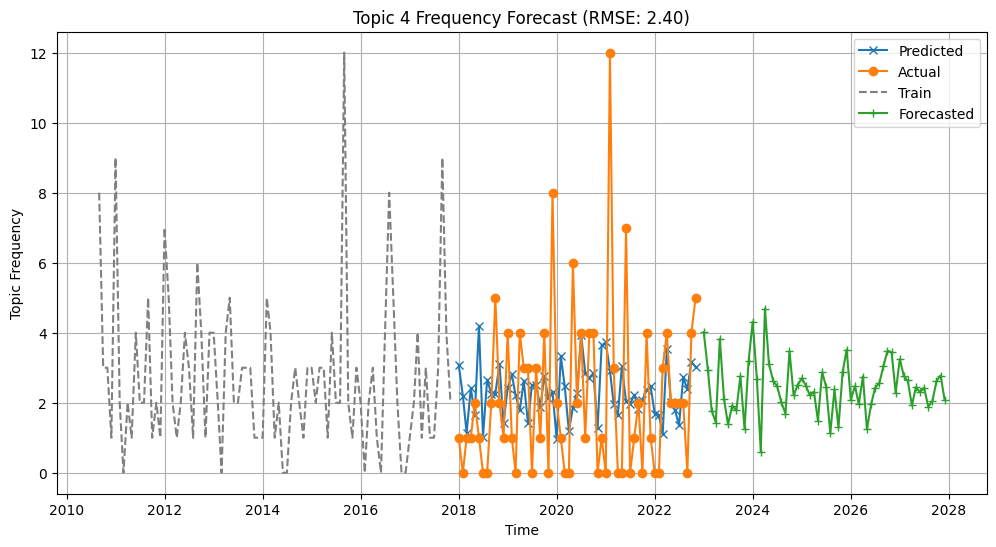

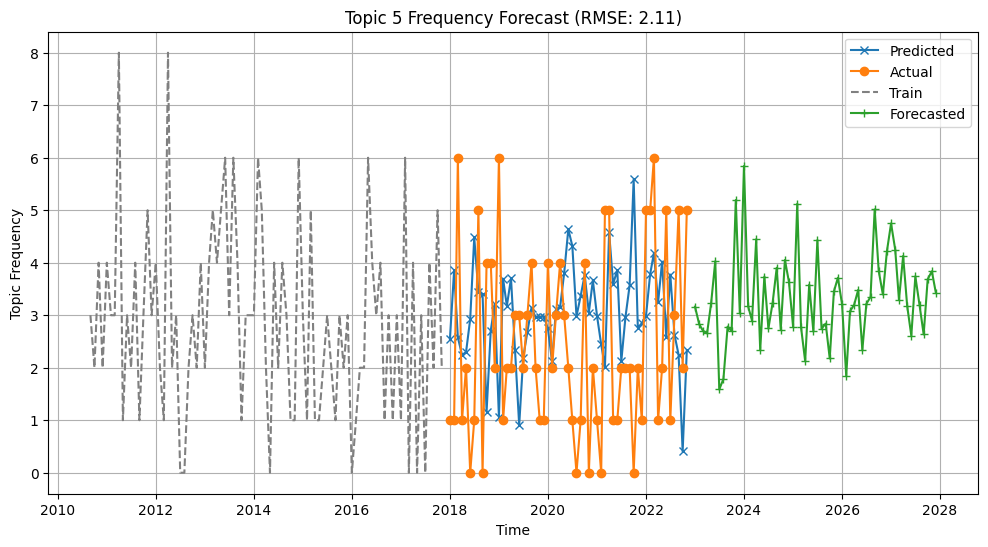

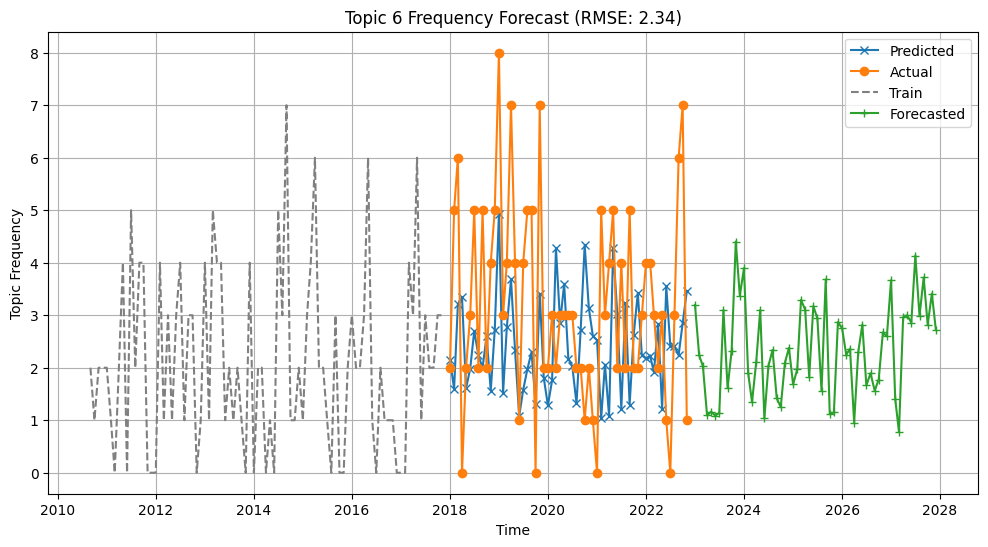

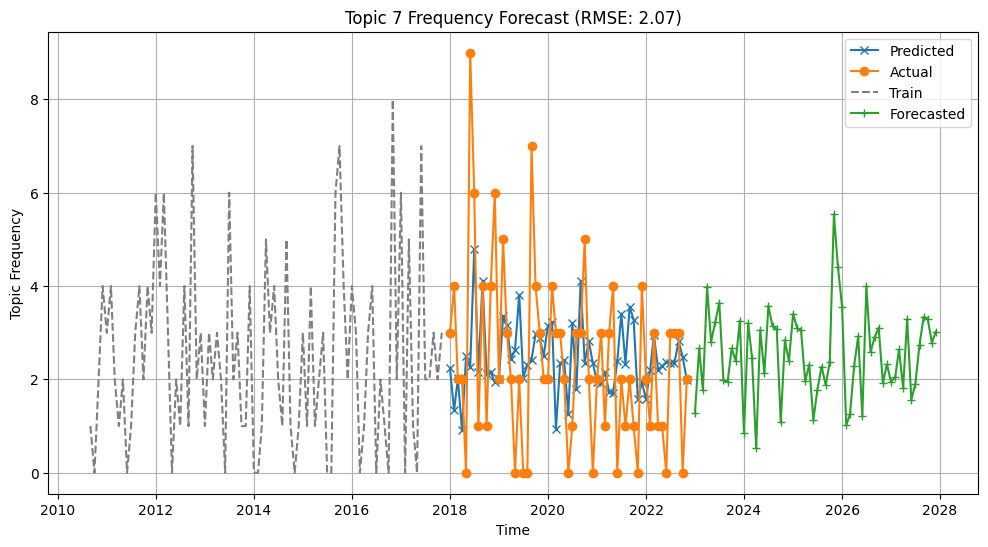

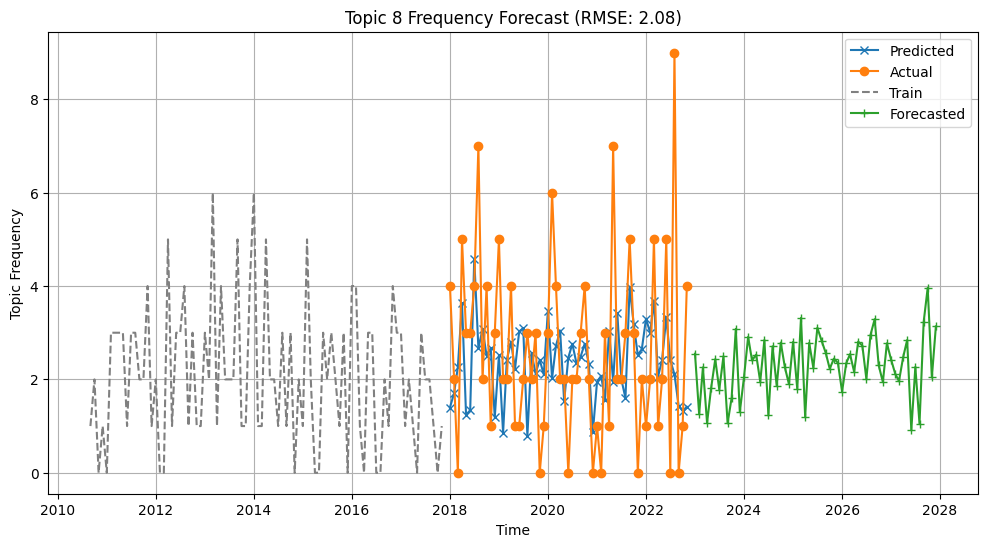

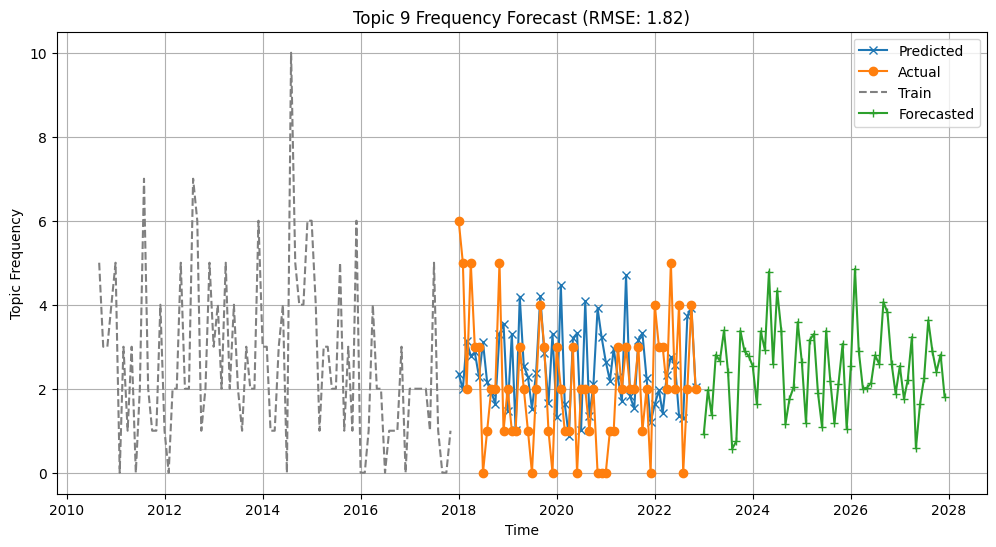

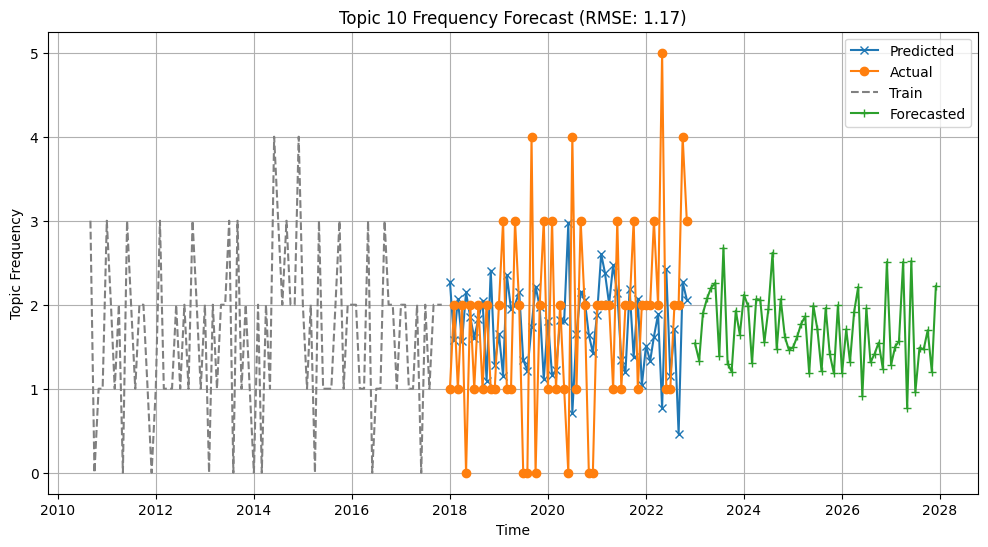

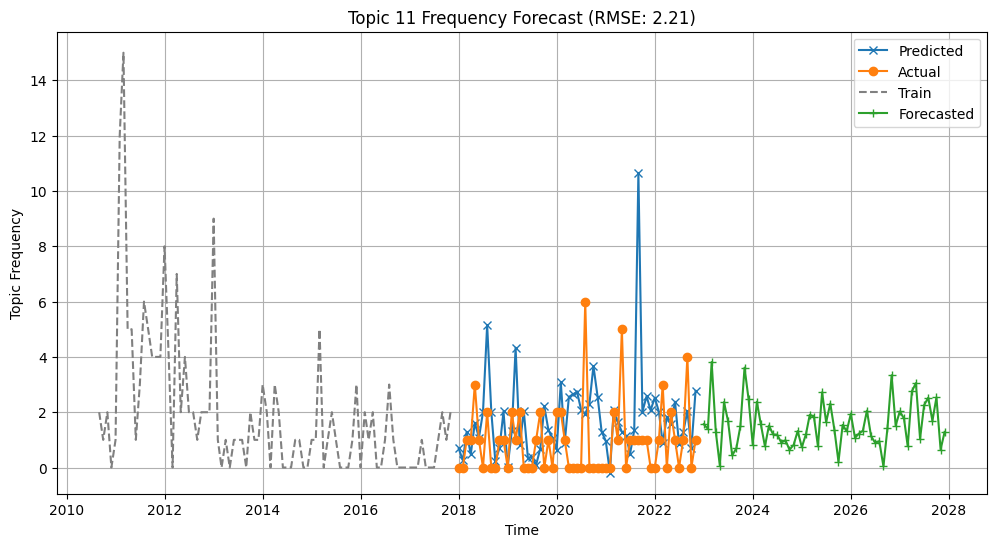

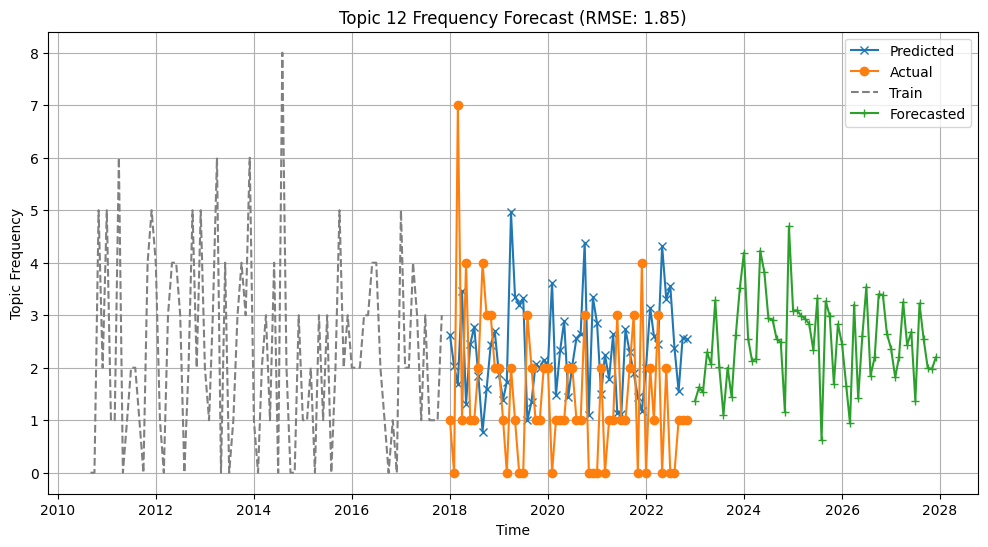

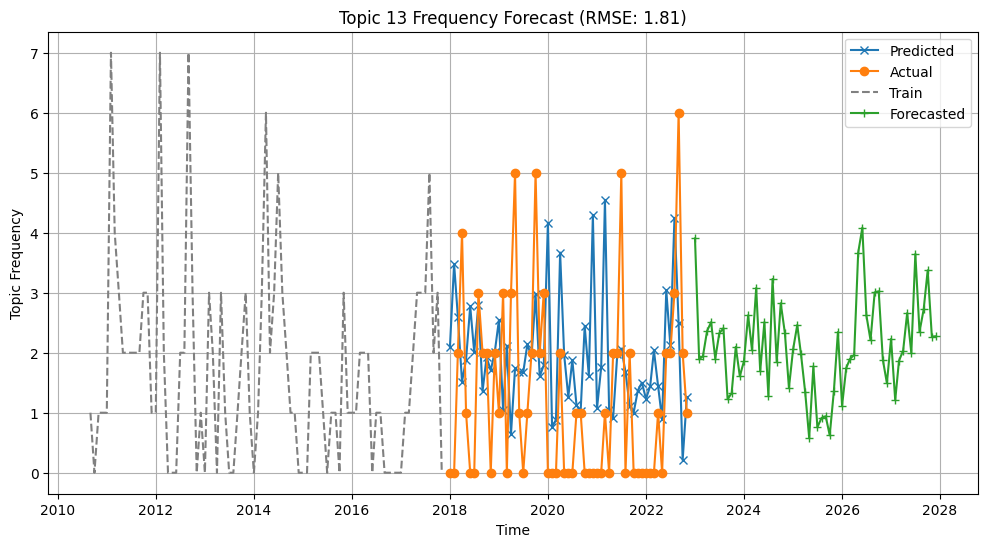

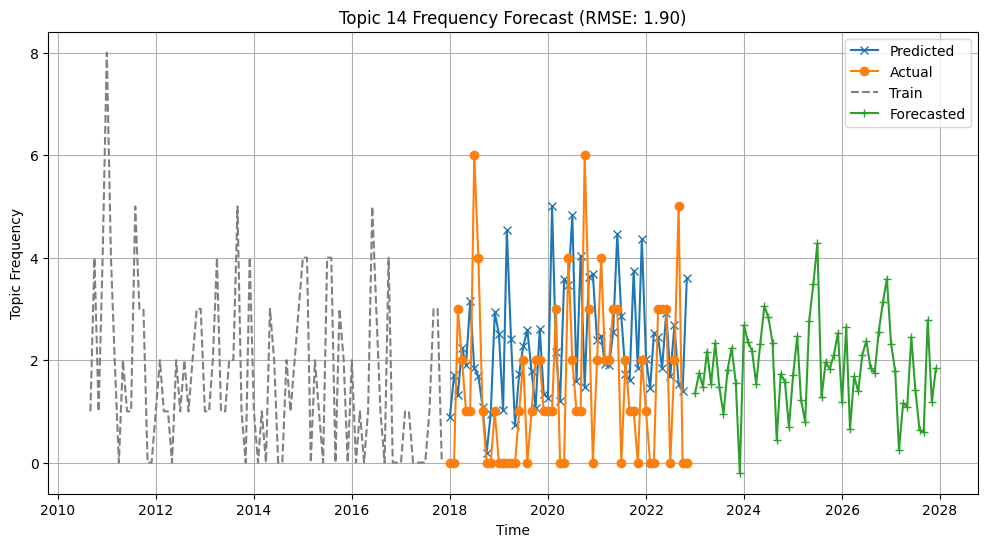

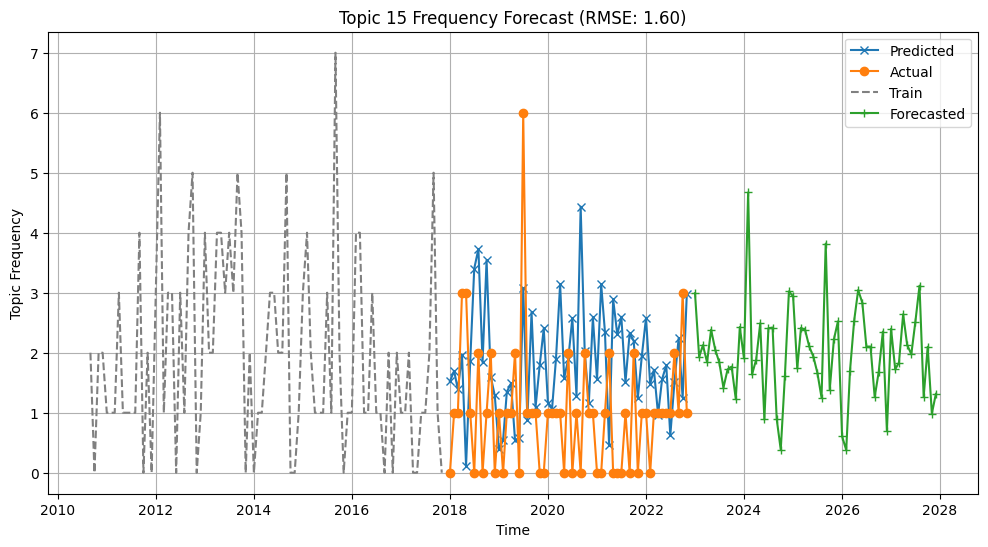

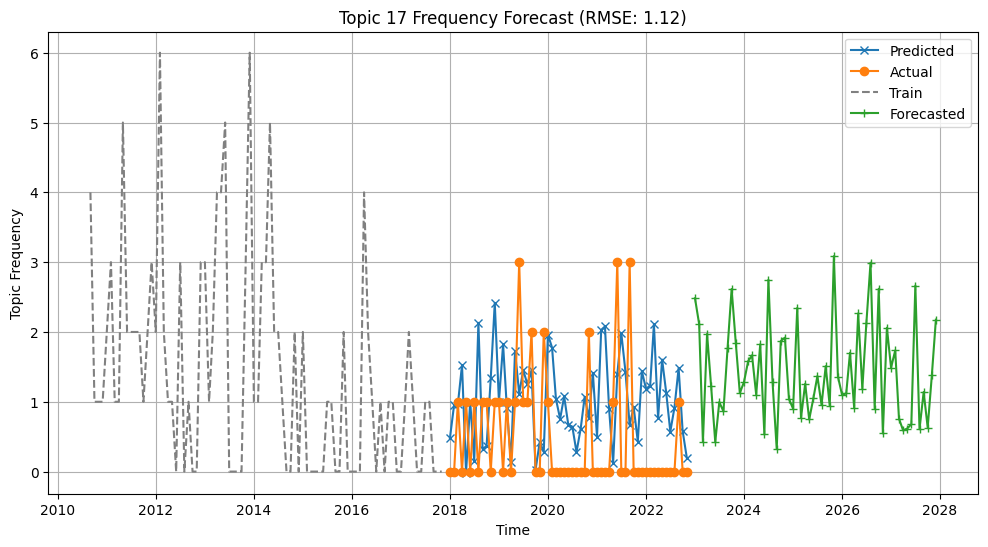

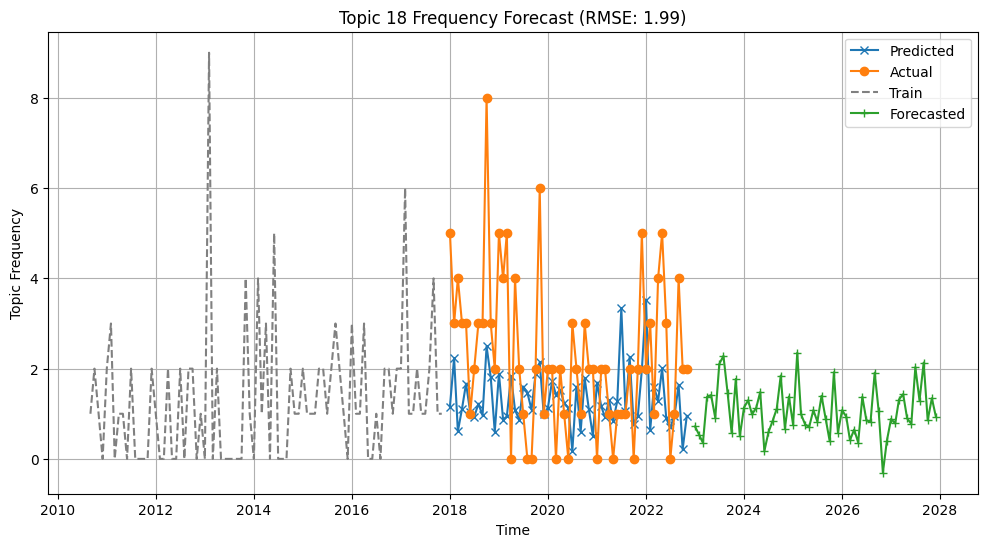

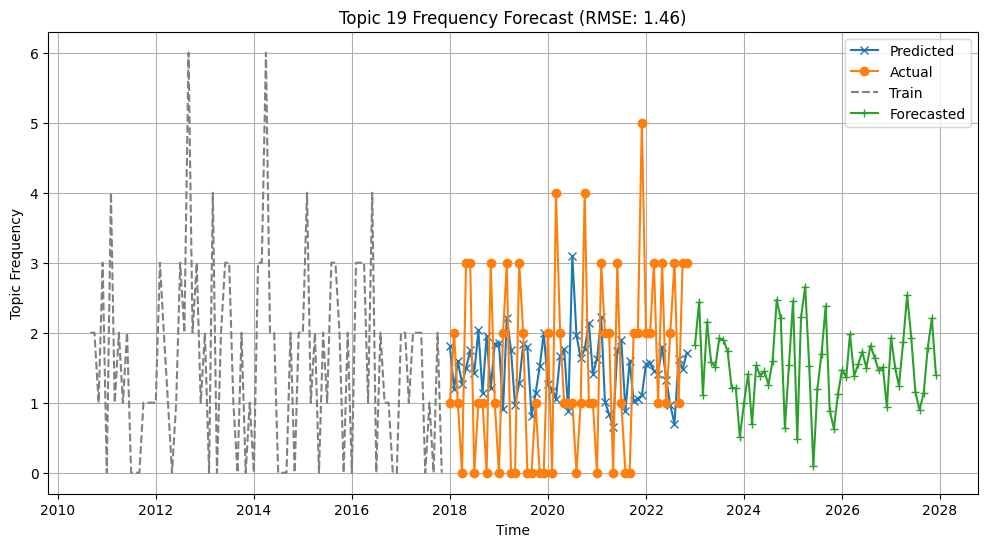

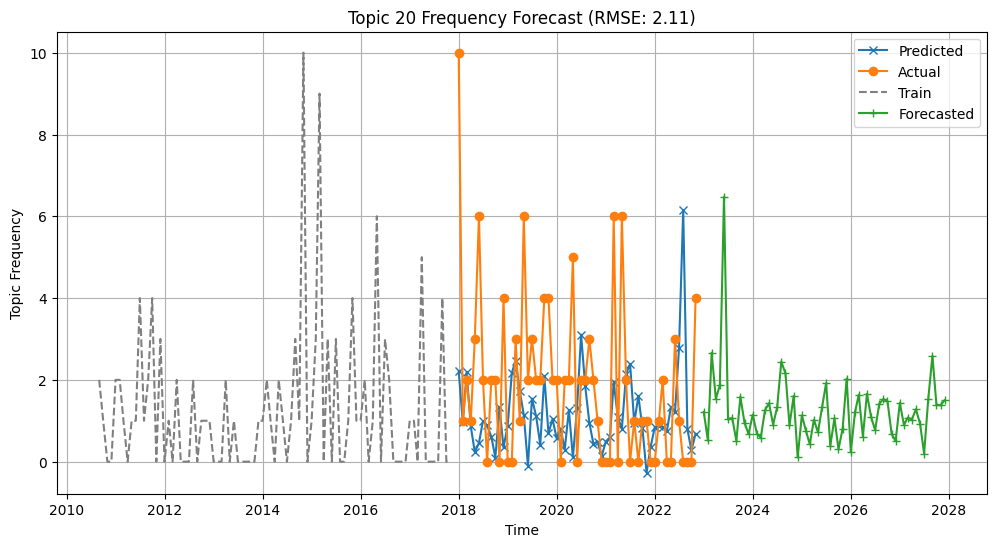

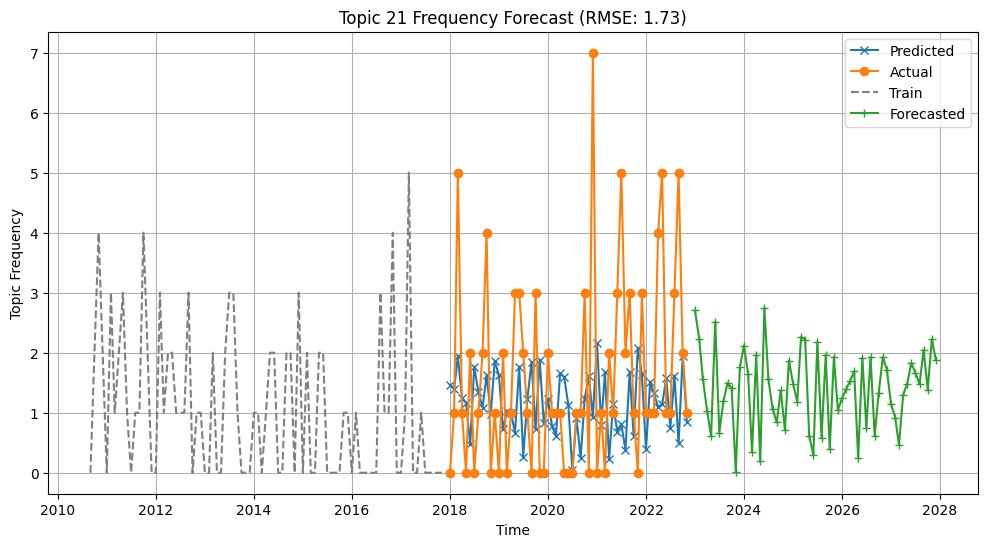

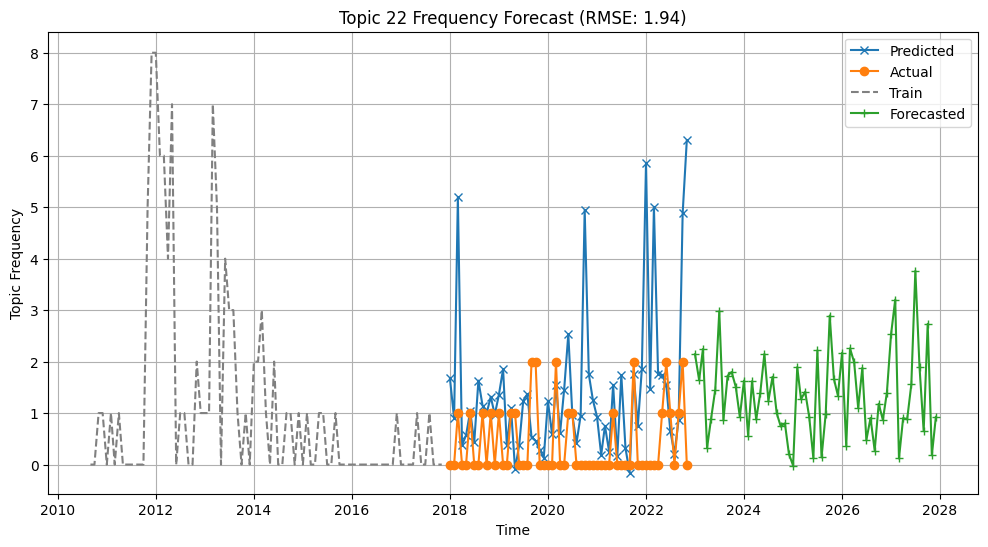

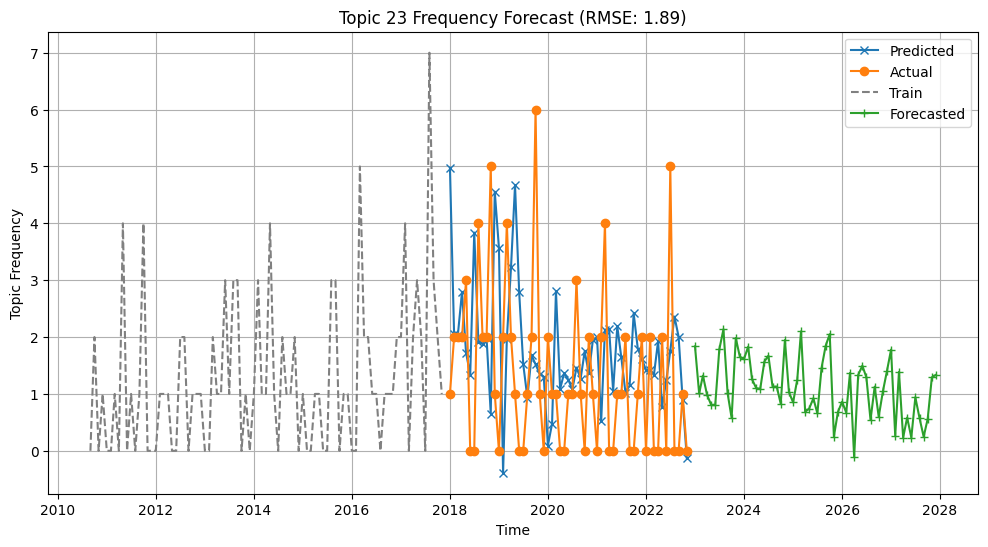

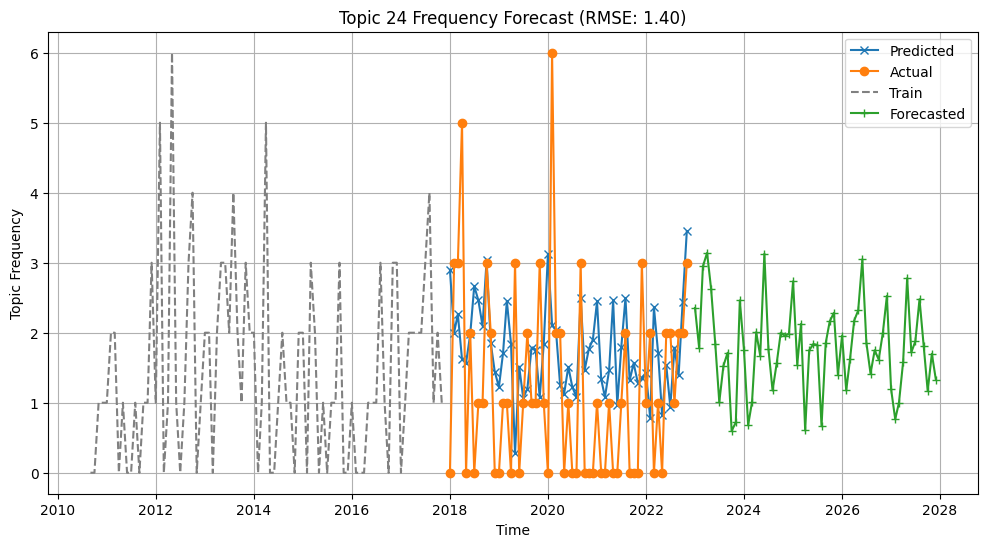

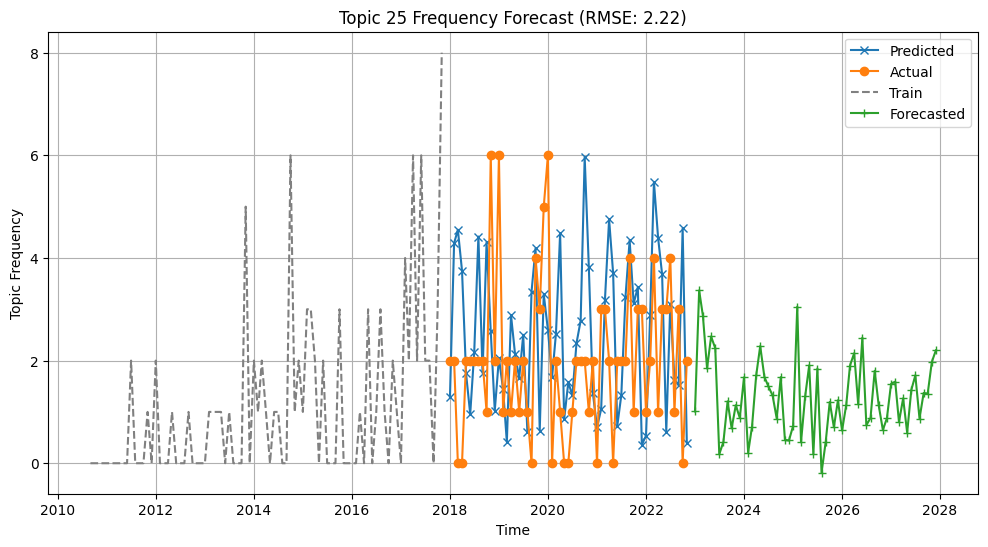

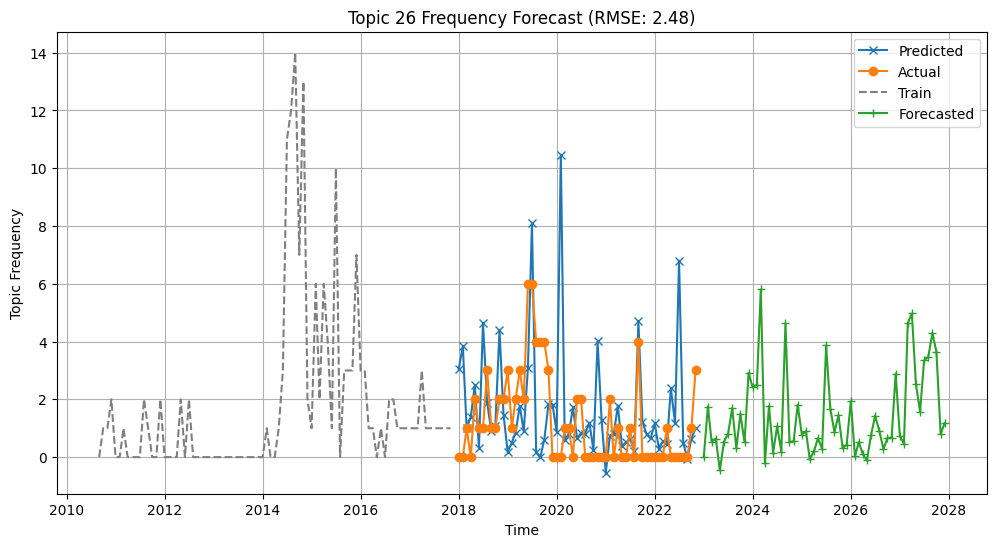

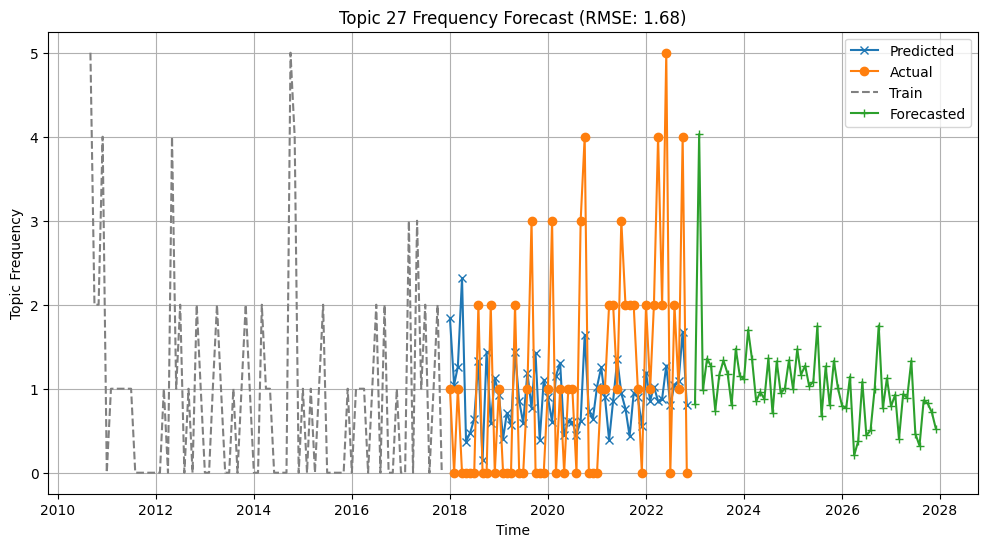

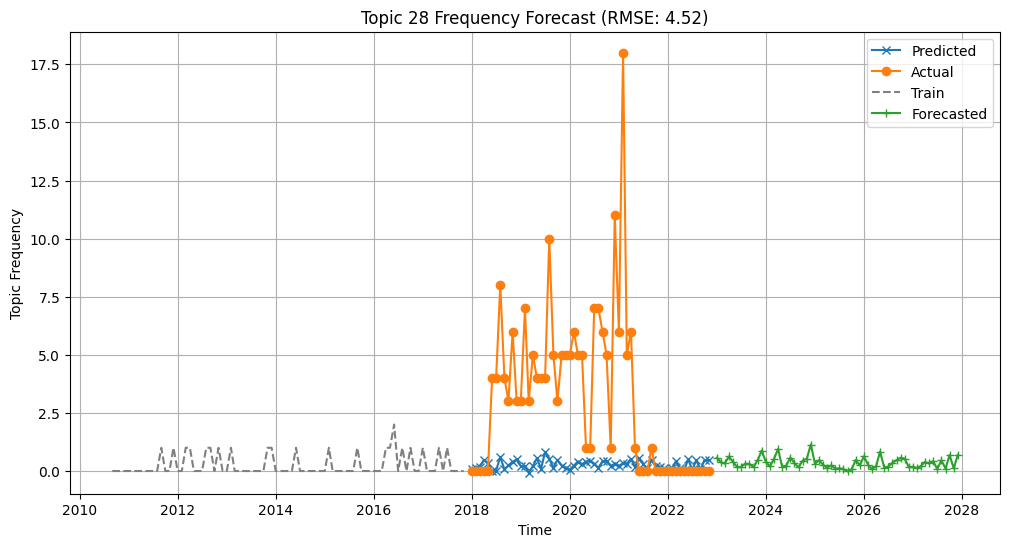

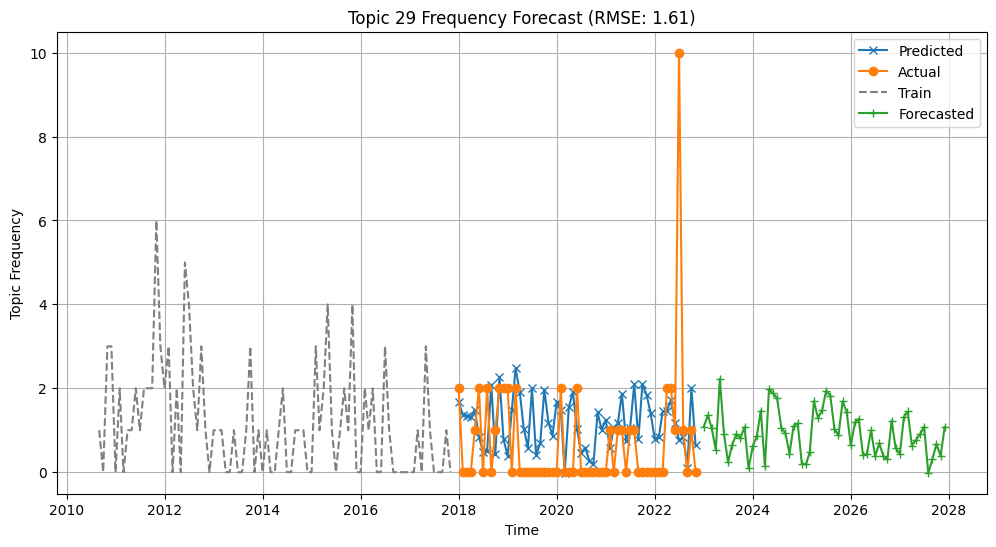

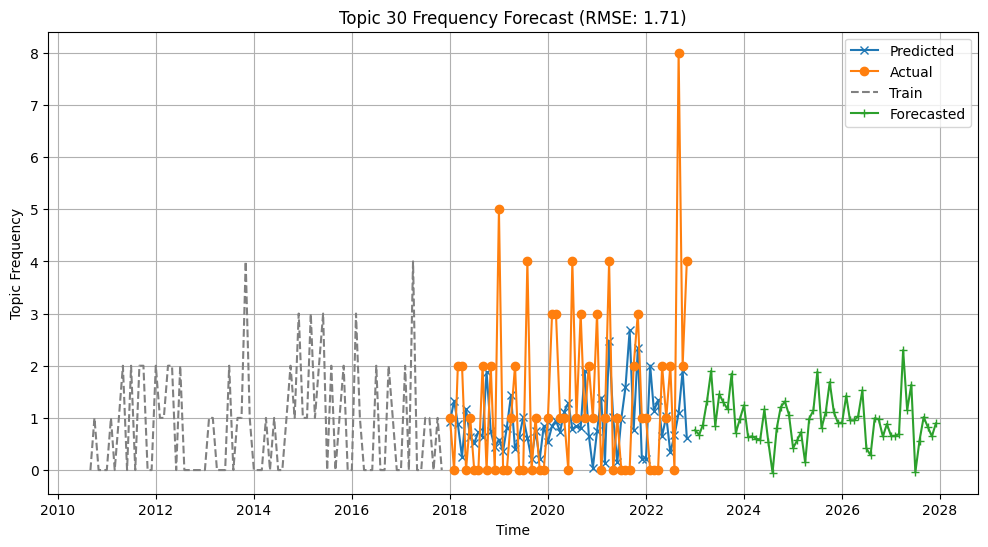

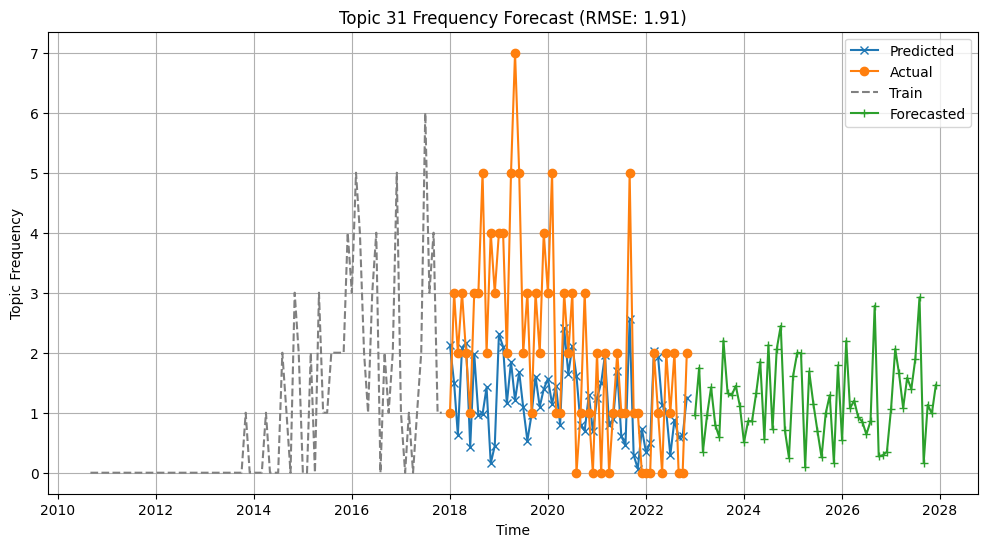

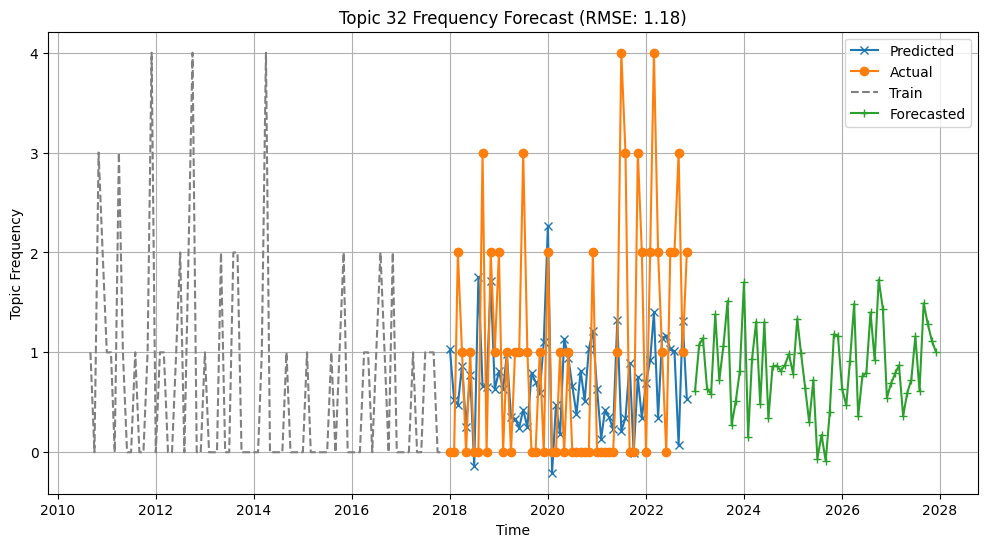

In [187]:
for i in range(1,33):
    if i != 16:
        plot_bertopic_data_into_future_monthly(i, 60)